# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.ReLU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.Dropout(p = 0.01),
            nn.ReLU(),
            nn.Linear(hidden2_size, output_size)
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Dropout(p=0.01, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 800 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/800, Iteration 1/12, Loss: 0.8043
Epoch 1/800, Iteration 2/12, Loss: 1.0600
Epoch 1/800, Iteration 3/12, Loss: 0.8801
Epoch 1/800, Iteration 4/12, Loss: 0.9085
Epoch 1/800, Iteration 5/12, Loss: 0.7994
Epoch 1/800, Iteration 6/12, Loss: 0.8025
Epoch 1/800, Iteration 7/12, Loss: 0.8237
Epoch 1/800, Iteration 8/12, Loss: 0.6562
Epoch 1/800, Iteration 9/12, Loss: 0.6279
Epoch 1/800, Iteration 10/12, Loss: 0.6301
Epoch 1/800, Iteration 11/12, Loss: 0.6984
Epoch 1/800, Iteration 12/12, Loss: 0.5072
Epoch 1/800, Iteration 13/12, Loss: 0.6022
Train Error: 
 Accuracy: 44.62%, Avg loss: 0.531842, MRE: 0.492452, MAE: 0.078695 

Test Error: 
 Accuracy: 48.0%, Avg loss: 0.482352, MRE: 0.392662, MAE: 0.070739 

Epoch 2/800, Iteration 1/12, Loss: 0.4297
Epoch 2/800, Iteration 2/12, Loss: 0.5360
Epoch 2/800, Iteration 3/12, Loss: 0.5247
Epoch 2/800, Iteration 4/12, Loss: 0.4353
Epoch 2/800, Iteration 5/12, Loss: 0.4454
Epoch 2/800, Iteration 6/12, Loss: 0.4618
Epoch 2/800, Iteration 7/12, Los

Test Error: 
 Accuracy: 87.0%, Avg loss: 0.029375, MRE: 0.075229, MAE: 0.013721 

Epoch 13/800, Iteration 1/12, Loss: 0.0459
Epoch 13/800, Iteration 2/12, Loss: 0.0240
Epoch 13/800, Iteration 3/12, Loss: 0.0247
Epoch 13/800, Iteration 4/12, Loss: 0.0372
Epoch 13/800, Iteration 5/12, Loss: 0.0350
Epoch 13/800, Iteration 6/12, Loss: 0.0384
Epoch 13/800, Iteration 7/12, Loss: 0.0228
Epoch 13/800, Iteration 8/12, Loss: 0.0284
Epoch 13/800, Iteration 9/12, Loss: 0.0172
Epoch 13/800, Iteration 10/12, Loss: 0.0374
Epoch 13/800, Iteration 11/12, Loss: 0.0260
Epoch 13/800, Iteration 12/12, Loss: 0.0688
Epoch 13/800, Iteration 13/12, Loss: 0.0169
Train Error: 
 Accuracy: 82.88%, Avg loss: 0.030000, MRE: 0.075354, MAE: 0.012911 

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.024996, MRE: 0.069561, MAE: 0.012888 

Epoch 14/800, Iteration 1/12, Loss: 0.0352
Epoch 14/800, Iteration 2/12, Loss: 0.0567
Epoch 14/800, Iteration 3/12, Loss: 0.0338
Epoch 14/800, Iteration 4/12, Loss: 0.0193
Epoch 14/800, Ite

Train Error: 
 Accuracy: 85.75%, Avg loss: 0.019814, MRE: 0.057920, MAE: 0.010051 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.015570, MRE: 0.052540, MAE: 0.010593 

Epoch 25/800, Iteration 1/12, Loss: 0.0103
Epoch 25/800, Iteration 2/12, Loss: 0.0192
Epoch 25/800, Iteration 3/12, Loss: 0.0116
Epoch 25/800, Iteration 4/12, Loss: 0.0367
Epoch 25/800, Iteration 5/12, Loss: 0.0214
Epoch 25/800, Iteration 6/12, Loss: 0.0240
Epoch 25/800, Iteration 7/12, Loss: 0.0215
Epoch 25/800, Iteration 8/12, Loss: 0.0243
Epoch 25/800, Iteration 9/12, Loss: 0.0148
Epoch 25/800, Iteration 10/12, Loss: 0.0100
Epoch 25/800, Iteration 11/12, Loss: 0.0150
Epoch 25/800, Iteration 12/12, Loss: 0.0253
Epoch 25/800, Iteration 13/12, Loss: 0.0392
Train Error: 
 Accuracy: 89.75%, Avg loss: 0.019152, MRE: 0.058389, MAE: 0.009893 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.016867, MRE: 0.052444, MAE: 0.010626 

Epoch 26/800, Iteration 1/12, Loss: 0.0258
Epoch 26/800, Iteration 2/12, Loss: 0.0320
Epoch 26/800, Itera

Train Error: 
 Accuracy: 91.25%, Avg loss: 0.015609, MRE: 0.053291, MAE: 0.008766 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.013750, MRE: 0.046815, MAE: 0.009553 

Epoch 37/800, Iteration 1/12, Loss: 0.0199
Epoch 37/800, Iteration 2/12, Loss: 0.0107
Epoch 37/800, Iteration 3/12, Loss: 0.0114
Epoch 37/800, Iteration 4/12, Loss: 0.0105
Epoch 37/800, Iteration 5/12, Loss: 0.0359
Epoch 37/800, Iteration 6/12, Loss: 0.0271
Epoch 37/800, Iteration 7/12, Loss: 0.0095
Epoch 37/800, Iteration 8/12, Loss: 0.0168
Epoch 37/800, Iteration 9/12, Loss: 0.0127
Epoch 37/800, Iteration 10/12, Loss: 0.0066
Epoch 37/800, Iteration 11/12, Loss: 0.0194
Epoch 37/800, Iteration 12/12, Loss: 0.0263
Epoch 37/800, Iteration 13/12, Loss: 0.0082
Train Error: 
 Accuracy: 89.75%, Avg loss: 0.015355, MRE: 0.051468, MAE: 0.008587 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.012977, MRE: 0.046346, MAE: 0.009431 

Epoch 38/800, Iteration 1/12, Loss: 0.0140
Epoch 38/800, Iteration 2/12, Loss: 0.0103
Epoch 38/800, Itera

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.011215, MRE: 0.043093, MAE: 0.008737 

Epoch 49/800, Iteration 1/12, Loss: 0.0125
Epoch 49/800, Iteration 2/12, Loss: 0.0235
Epoch 49/800, Iteration 3/12, Loss: 0.0146
Epoch 49/800, Iteration 4/12, Loss: 0.0252
Epoch 49/800, Iteration 5/12, Loss: 0.0055
Epoch 49/800, Iteration 6/12, Loss: 0.0137
Epoch 49/800, Iteration 7/12, Loss: 0.0145
Epoch 49/800, Iteration 8/12, Loss: 0.0111
Epoch 49/800, Iteration 9/12, Loss: 0.0105
Epoch 49/800, Iteration 10/12, Loss: 0.0097
Epoch 49/800, Iteration 11/12, Loss: 0.0185
Epoch 49/800, Iteration 12/12, Loss: 0.0140
Epoch 49/800, Iteration 13/12, Loss: 0.0038
Train Error: 
 Accuracy: 93.0%, Avg loss: 0.012710, MRE: 0.048553, MAE: 0.007923 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.011865, MRE: 0.043507, MAE: 0.008864 

Epoch 50/800, Iteration 1/12, Loss: 0.0084
Epoch 50/800, Iteration 2/12, Loss: 0.0123
Epoch 50/800, Iteration 3/12, Loss: 0.0201
Epoch 50/800, Iteration 4/12, Loss: 0.0062
Epoch 50/800, Iter

Train Error: 
 Accuracy: 91.0%, Avg loss: 0.012759, MRE: 0.050082, MAE: 0.007585 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.009532, MRE: 0.039731, MAE: 0.008032 

Epoch 61/800, Iteration 1/12, Loss: 0.0154
Epoch 61/800, Iteration 2/12, Loss: 0.0166
Epoch 61/800, Iteration 3/12, Loss: 0.0080
Epoch 61/800, Iteration 4/12, Loss: 0.0066
Epoch 61/800, Iteration 5/12, Loss: 0.0069
Epoch 61/800, Iteration 6/12, Loss: 0.0150
Epoch 61/800, Iteration 7/12, Loss: 0.0171
Epoch 61/800, Iteration 8/12, Loss: 0.0152
Epoch 61/800, Iteration 9/12, Loss: 0.0084
Epoch 61/800, Iteration 10/12, Loss: 0.0075
Epoch 61/800, Iteration 11/12, Loss: 0.0078
Epoch 61/800, Iteration 12/12, Loss: 0.0242
Epoch 61/800, Iteration 13/12, Loss: 0.0119
Train Error: 
 Accuracy: 93.38%, Avg loss: 0.013002, MRE: 0.045183, MAE: 0.007627 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.010672, MRE: 0.040736, MAE: 0.008309 

Epoch 62/800, Iteration 1/12, Loss: 0.0061
Epoch 62/800, Iteration 2/12, Loss: 0.0105
Epoch 62/800, Iterat

Epoch 72/800, Iteration 8/12, Loss: 0.0118
Epoch 72/800, Iteration 9/12, Loss: 0.0245
Epoch 72/800, Iteration 10/12, Loss: 0.0059
Epoch 72/800, Iteration 11/12, Loss: 0.0106
Epoch 72/800, Iteration 12/12, Loss: 0.0060
Epoch 72/800, Iteration 13/12, Loss: 0.0058
Train Error: 
 Accuracy: 92.38%, Avg loss: 0.010246, MRE: 0.040483, MAE: 0.006962 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.008828, MRE: 0.037155, MAE: 0.007626 

Epoch 73/800, Iteration 1/12, Loss: 0.0050
Epoch 73/800, Iteration 2/12, Loss: 0.0113
Epoch 73/800, Iteration 3/12, Loss: 0.0162
Epoch 73/800, Iteration 4/12, Loss: 0.0198
Epoch 73/800, Iteration 5/12, Loss: 0.0070
Epoch 73/800, Iteration 6/12, Loss: 0.0059
Epoch 73/800, Iteration 7/12, Loss: 0.0092
Epoch 73/800, Iteration 8/12, Loss: 0.0122
Epoch 73/800, Iteration 9/12, Loss: 0.0112
Epoch 73/800, Iteration 10/12, Loss: 0.0107
Epoch 73/800, Iteration 11/12, Loss: 0.0155
Epoch 73/800, Iteration 12/12, Loss: 0.0143
Epoch 73/800, Iteration 13/12, Loss: 0.0103
Train Err

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.007985, MRE: 0.035381, MAE: 0.007249 

Epoch 84/800, Iteration 1/12, Loss: 0.0076
Epoch 84/800, Iteration 2/12, Loss: 0.0076
Epoch 84/800, Iteration 3/12, Loss: 0.0075
Epoch 84/800, Iteration 4/12, Loss: 0.0099
Epoch 84/800, Iteration 5/12, Loss: 0.0089
Epoch 84/800, Iteration 6/12, Loss: 0.0127
Epoch 84/800, Iteration 7/12, Loss: 0.0099
Epoch 84/800, Iteration 8/12, Loss: 0.0059
Epoch 84/800, Iteration 9/12, Loss: 0.0035
Epoch 84/800, Iteration 10/12, Loss: 0.0216
Epoch 84/800, Iteration 11/12, Loss: 0.0109
Epoch 84/800, Iteration 12/12, Loss: 0.0221
Epoch 84/800, Iteration 13/12, Loss: 0.0033
Train Error: 
 Accuracy: 93.88%, Avg loss: 0.009711, MRE: 0.038610, MAE: 0.006749 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.008891, MRE: 0.036573, MAE: 0.007519 

Epoch 85/800, Iteration 1/12, Loss: 0.0084
Epoch 85/800, Iteration 2/12, Loss: 0.0094
Epoch 85/800, Iteration 3/12, Loss: 0.0083
Epoch 85/800, Iteration 4/12, Loss: 0.0206
Epoch 85/800, Ite

Epoch 96/800, Iteration 5/12, Loss: 0.0050
Epoch 96/800, Iteration 6/12, Loss: 0.0105
Epoch 96/800, Iteration 7/12, Loss: 0.0288
Epoch 96/800, Iteration 8/12, Loss: 0.0074
Epoch 96/800, Iteration 9/12, Loss: 0.0043
Epoch 96/800, Iteration 10/12, Loss: 0.0067
Epoch 96/800, Iteration 11/12, Loss: 0.0115
Epoch 96/800, Iteration 12/12, Loss: 0.0053
Epoch 96/800, Iteration 13/12, Loss: 0.0093
Train Error: 
 Accuracy: 91.5%, Avg loss: 0.008681, MRE: 0.036281, MAE: 0.006466 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.007326, MRE: 0.034272, MAE: 0.006944 

Epoch 97/800, Iteration 1/12, Loss: 0.0145
Epoch 97/800, Iteration 2/12, Loss: 0.0206
Epoch 97/800, Iteration 3/12, Loss: 0.0074
Epoch 97/800, Iteration 4/12, Loss: 0.0108
Epoch 97/800, Iteration 5/12, Loss: 0.0138
Epoch 97/800, Iteration 6/12, Loss: 0.0121
Epoch 97/800, Iteration 7/12, Loss: 0.0088
Epoch 97/800, Iteration 8/12, Loss: 0.0066
Epoch 97/800, Iteration 9/12, Loss: 0.0061
Epoch 97/800, Iteration 10/12, Loss: 0.0041
Epoch 97/800,

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.007599, MRE: 0.032823, MAE: 0.006809 

Epoch 108/800, Iteration 1/12, Loss: 0.0055
Epoch 108/800, Iteration 2/12, Loss: 0.0035
Epoch 108/800, Iteration 3/12, Loss: 0.0134
Epoch 108/800, Iteration 4/12, Loss: 0.0149
Epoch 108/800, Iteration 5/12, Loss: 0.0073
Epoch 108/800, Iteration 6/12, Loss: 0.0081
Epoch 108/800, Iteration 7/12, Loss: 0.0133
Epoch 108/800, Iteration 8/12, Loss: 0.0083
Epoch 108/800, Iteration 9/12, Loss: 0.0133
Epoch 108/800, Iteration 10/12, Loss: 0.0036
Epoch 108/800, Iteration 11/12, Loss: 0.0050
Epoch 108/800, Iteration 12/12, Loss: 0.0140
Epoch 108/800, Iteration 13/12, Loss: 0.0078
Train Error: 
 Accuracy: 93.88%, Avg loss: 0.007918, MRE: 0.034778, MAE: 0.006119 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.007325, MRE: 0.032509, MAE: 0.006700 

Epoch 109/800, Iteration 1/12, Loss: 0.0066
Epoch 109/800, Iteration 2/12, Loss: 0.0100
Epoch 109/800, Iteration 3/12, Loss: 0.0228
Epoch 109/800, Iteration 4/12, Loss: 0.0099


Train Error: 
 Accuracy: 92.88%, Avg loss: 0.007657, MRE: 0.033173, MAE: 0.005972 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.006193, MRE: 0.030765, MAE: 0.006289 

Epoch 120/800, Iteration 1/12, Loss: 0.0144
Epoch 120/800, Iteration 2/12, Loss: 0.0042
Epoch 120/800, Iteration 3/12, Loss: 0.0181
Epoch 120/800, Iteration 4/12, Loss: 0.0104
Epoch 120/800, Iteration 5/12, Loss: 0.0140
Epoch 120/800, Iteration 6/12, Loss: 0.0055
Epoch 120/800, Iteration 7/12, Loss: 0.0061
Epoch 120/800, Iteration 8/12, Loss: 0.0054
Epoch 120/800, Iteration 9/12, Loss: 0.0076
Epoch 120/800, Iteration 10/12, Loss: 0.0092
Epoch 120/800, Iteration 11/12, Loss: 0.0057
Epoch 120/800, Iteration 12/12, Loss: 0.0043
Epoch 120/800, Iteration 13/12, Loss: 0.0032
Train Error: 
 Accuracy: 93.75%, Avg loss: 0.008048, MRE: 0.033366, MAE: 0.005969 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.006539, MRE: 0.031065, MAE: 0.006350 

Epoch 121/800, Iteration 1/12, Loss: 0.0140
Epoch 121/800, Iteration 2/12, Loss: 0.0109
Epoc

Train Error: 
 Accuracy: 95.25%, Avg loss: 0.007501, MRE: 0.037409, MAE: 0.006002 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.007337, MRE: 0.032032, MAE: 0.006571 

Epoch 132/800, Iteration 1/12, Loss: 0.0068
Epoch 132/800, Iteration 2/12, Loss: 0.0062
Epoch 132/800, Iteration 3/12, Loss: 0.0071
Epoch 132/800, Iteration 4/12, Loss: 0.0045
Epoch 132/800, Iteration 5/12, Loss: 0.0054
Epoch 132/800, Iteration 6/12, Loss: 0.0064
Epoch 132/800, Iteration 7/12, Loss: 0.0068
Epoch 132/800, Iteration 8/12, Loss: 0.0153
Epoch 132/800, Iteration 9/12, Loss: 0.0106
Epoch 132/800, Iteration 10/12, Loss: 0.0076
Epoch 132/800, Iteration 11/12, Loss: 0.0097
Epoch 132/800, Iteration 12/12, Loss: 0.0044
Epoch 132/800, Iteration 13/12, Loss: 0.0213
Train Error: 
 Accuracy: 94.62%, Avg loss: 0.007026, MRE: 0.032208, MAE: 0.005741 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.006937, MRE: 0.030796, MAE: 0.006368 

Epoch 133/800, Iteration 1/12, Loss: 0.0068
Epoch 133/800, Iteration 2/12, Loss: 0.0057
Epoc

Epoch 143/800, Iteration 9/12, Loss: 0.0178
Epoch 143/800, Iteration 10/12, Loss: 0.0091
Epoch 143/800, Iteration 11/12, Loss: 0.0062
Epoch 143/800, Iteration 12/12, Loss: 0.0043
Epoch 143/800, Iteration 13/12, Loss: 0.0043
Train Error: 
 Accuracy: 94.12%, Avg loss: 0.006643, MRE: 0.031913, MAE: 0.005523 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.005949, MRE: 0.029565, MAE: 0.006009 

Epoch 144/800, Iteration 1/12, Loss: 0.0047
Epoch 144/800, Iteration 2/12, Loss: 0.0091
Epoch 144/800, Iteration 3/12, Loss: 0.0096
Epoch 144/800, Iteration 4/12, Loss: 0.0075
Epoch 144/800, Iteration 5/12, Loss: 0.0044
Epoch 144/800, Iteration 6/12, Loss: 0.0123
Epoch 144/800, Iteration 7/12, Loss: 0.0038
Epoch 144/800, Iteration 8/12, Loss: 0.0152
Epoch 144/800, Iteration 9/12, Loss: 0.0103
Epoch 144/800, Iteration 10/12, Loss: 0.0055
Epoch 144/800, Iteration 11/12, Loss: 0.0029
Epoch 144/800, Iteration 12/12, Loss: 0.0052
Epoch 144/800, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 94.0%, Av

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.005711, MRE: 0.028967, MAE: 0.005854 

Epoch 155/800, Iteration 1/12, Loss: 0.0138
Epoch 155/800, Iteration 2/12, Loss: 0.0041
Epoch 155/800, Iteration 3/12, Loss: 0.0066
Epoch 155/800, Iteration 4/12, Loss: 0.0038
Epoch 155/800, Iteration 5/12, Loss: 0.0120
Epoch 155/800, Iteration 6/12, Loss: 0.0123
Epoch 155/800, Iteration 7/12, Loss: 0.0063
Epoch 155/800, Iteration 8/12, Loss: 0.0098
Epoch 155/800, Iteration 9/12, Loss: 0.0059
Epoch 155/800, Iteration 10/12, Loss: 0.0058
Epoch 155/800, Iteration 11/12, Loss: 0.0044
Epoch 155/800, Iteration 12/12, Loss: 0.0043
Epoch 155/800, Iteration 13/12, Loss: 0.0048
Train Error: 
 Accuracy: 94.0%, Avg loss: 0.006181, MRE: 0.029917, MAE: 0.005298 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.005447, MRE: 0.029115, MAE: 0.005812 

Epoch 156/800, Iteration 1/12, Loss: 0.0073
Epoch 156/800, Iteration 2/12, Loss: 0.0042
Epoch 156/800, Iteration 3/12, Loss: 0.0061
Epoch 156/800, Iteration 4/12, Loss: 0.0039
E

Train Error: 
 Accuracy: 94.5%, Avg loss: 0.005916, MRE: 0.029384, MAE: 0.005182 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.005249, MRE: 0.028129, MAE: 0.005674 

Epoch 167/800, Iteration 1/12, Loss: 0.0057
Epoch 167/800, Iteration 2/12, Loss: 0.0053
Epoch 167/800, Iteration 3/12, Loss: 0.0042
Epoch 167/800, Iteration 4/12, Loss: 0.0049
Epoch 167/800, Iteration 5/12, Loss: 0.0058
Epoch 167/800, Iteration 6/12, Loss: 0.0089
Epoch 167/800, Iteration 7/12, Loss: 0.0070
Epoch 167/800, Iteration 8/12, Loss: 0.0037
Epoch 167/800, Iteration 9/12, Loss: 0.0137
Epoch 167/800, Iteration 10/12, Loss: 0.0065
Epoch 167/800, Iteration 11/12, Loss: 0.0134
Epoch 167/800, Iteration 12/12, Loss: 0.0076
Epoch 167/800, Iteration 13/12, Loss: 0.0029
Train Error: 
 Accuracy: 94.62%, Avg loss: 0.006036, MRE: 0.029499, MAE: 0.005201 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.005242, MRE: 0.028248, MAE: 0.005671 

Epoch 168/800, Iteration 1/12, Loss: 0.0089
Epoch 168/800, Iteration 2/12, Loss: 0.0048
Epoch

Train Error: 
 Accuracy: 94.5%, Avg loss: 0.005647, MRE: 0.028908, MAE: 0.005029 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.004865, MRE: 0.027986, MAE: 0.005505 

Epoch 179/800, Iteration 1/12, Loss: 0.0066
Epoch 179/800, Iteration 2/12, Loss: 0.0079
Epoch 179/800, Iteration 3/12, Loss: 0.0038
Epoch 179/800, Iteration 4/12, Loss: 0.0084
Epoch 179/800, Iteration 5/12, Loss: 0.0162
Epoch 179/800, Iteration 6/12, Loss: 0.0082
Epoch 179/800, Iteration 7/12, Loss: 0.0044
Epoch 179/800, Iteration 8/12, Loss: 0.0051
Epoch 179/800, Iteration 9/12, Loss: 0.0078
Epoch 179/800, Iteration 10/12, Loss: 0.0055
Epoch 179/800, Iteration 11/12, Loss: 0.0023
Epoch 179/800, Iteration 12/12, Loss: 0.0042
Epoch 179/800, Iteration 13/12, Loss: 0.0051
Train Error: 
 Accuracy: 95.25%, Avg loss: 0.005785, MRE: 0.028749, MAE: 0.005032 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.005007, MRE: 0.027752, MAE: 0.005519 

Epoch 180/800, Iteration 1/12, Loss: 0.0032
Epoch 180/800, Iteration 2/12, Loss: 0.0022
Epoch

Epoch 190/800, Iteration 13/12, Loss: 0.0034
Train Error: 
 Accuracy: 94.62%, Avg loss: 0.005563, MRE: 0.028510, MAE: 0.004952 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.004811, MRE: 0.027705, MAE: 0.005441 

Epoch 191/800, Iteration 1/12, Loss: 0.0116
Epoch 191/800, Iteration 2/12, Loss: 0.0038
Epoch 191/800, Iteration 3/12, Loss: 0.0066
Epoch 191/800, Iteration 4/12, Loss: 0.0092
Epoch 191/800, Iteration 5/12, Loss: 0.0074
Epoch 191/800, Iteration 6/12, Loss: 0.0041
Epoch 191/800, Iteration 7/12, Loss: 0.0029
Epoch 191/800, Iteration 8/12, Loss: 0.0108
Epoch 191/800, Iteration 9/12, Loss: 0.0034
Epoch 191/800, Iteration 10/12, Loss: 0.0031
Epoch 191/800, Iteration 11/12, Loss: 0.0077
Epoch 191/800, Iteration 12/12, Loss: 0.0033
Epoch 191/800, Iteration 13/12, Loss: 0.0093
Train Error: 
 Accuracy: 94.88%, Avg loss: 0.005480, MRE: 0.028711, MAE: 0.004933 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.004693, MRE: 0.027292, MAE: 0.005328 

Epoch 192/800, Iteration 1/12, Loss: 0.0063
Epo

Train Error: 
 Accuracy: 95.88%, Avg loss: 0.005274, MRE: 0.028567, MAE: 0.004875 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.004945, MRE: 0.027244, MAE: 0.005388 

Epoch 203/800, Iteration 1/12, Loss: 0.0062
Epoch 203/800, Iteration 2/12, Loss: 0.0050
Epoch 203/800, Iteration 3/12, Loss: 0.0043
Epoch 203/800, Iteration 4/12, Loss: 0.0062
Epoch 203/800, Iteration 5/12, Loss: 0.0086
Epoch 203/800, Iteration 6/12, Loss: 0.0086
Epoch 203/800, Iteration 7/12, Loss: 0.0032
Epoch 203/800, Iteration 8/12, Loss: 0.0040
Epoch 203/800, Iteration 9/12, Loss: 0.0041
Epoch 203/800, Iteration 10/12, Loss: 0.0056
Epoch 203/800, Iteration 11/12, Loss: 0.0032
Epoch 203/800, Iteration 12/12, Loss: 0.0073
Epoch 203/800, Iteration 13/12, Loss: 0.0161
Train Error: 
 Accuracy: 95.88%, Avg loss: 0.005175, MRE: 0.027830, MAE: 0.004842 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.005324, MRE: 0.027620, MAE: 0.005483 

Epoch 204/800, Iteration 1/12, Loss: 0.0045
Epoch 204/800, Iteration 2/12, Loss: 0.0071
Epoc

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.004647, MRE: 0.026807, MAE: 0.005224 

Epoch 214/800, Iteration 1/12, Loss: 0.0040
Epoch 214/800, Iteration 2/12, Loss: 0.0046
Epoch 214/800, Iteration 3/12, Loss: 0.0041
Epoch 214/800, Iteration 4/12, Loss: 0.0035
Epoch 214/800, Iteration 5/12, Loss: 0.0068
Epoch 214/800, Iteration 6/12, Loss: 0.0045
Epoch 214/800, Iteration 7/12, Loss: 0.0046
Epoch 214/800, Iteration 8/12, Loss: 0.0035
Epoch 214/800, Iteration 9/12, Loss: 0.0100
Epoch 214/800, Iteration 10/12, Loss: 0.0049
Epoch 214/800, Iteration 11/12, Loss: 0.0043
Epoch 214/800, Iteration 12/12, Loss: 0.0139
Epoch 214/800, Iteration 13/12, Loss: 0.0137
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.005141, MRE: 0.028618, MAE: 0.004873 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.005344, MRE: 0.027597, MAE: 0.005462 

Epoch 215/800, Iteration 1/12, Loss: 0.0023
Epoch 215/800, Iteration 2/12, Loss: 0.0031
Epoch 215/800, Iteration 3/12, Loss: 0.0038
Epoch 215/800, Iteration 4/12, Loss: 0.0045
E

Train Error: 
 Accuracy: 95.88%, Avg loss: 0.004815, MRE: 0.027126, MAE: 0.004647 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.004428, MRE: 0.026118, MAE: 0.005119 

Epoch 226/800, Iteration 1/12, Loss: 0.0104
Epoch 226/800, Iteration 2/12, Loss: 0.0051
Epoch 226/800, Iteration 3/12, Loss: 0.0035
Epoch 226/800, Iteration 4/12, Loss: 0.0060
Epoch 226/800, Iteration 5/12, Loss: 0.0048
Epoch 226/800, Iteration 6/12, Loss: 0.0122
Epoch 226/800, Iteration 7/12, Loss: 0.0020
Epoch 226/800, Iteration 8/12, Loss: 0.0069
Epoch 226/800, Iteration 9/12, Loss: 0.0048
Epoch 226/800, Iteration 10/12, Loss: 0.0055
Epoch 226/800, Iteration 11/12, Loss: 0.0040
Epoch 226/800, Iteration 12/12, Loss: 0.0027
Epoch 226/800, Iteration 13/12, Loss: 0.0023
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.004748, MRE: 0.028165, MAE: 0.004617 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.004377, MRE: 0.026104, MAE: 0.005080 

Epoch 227/800, Iteration 1/12, Loss: 0.0058
Epoch 227/800, Iteration 2/12, Loss: 0.0070
Epoch

Epoch 238/800, Iteration 4/12, Loss: 0.0064
Epoch 238/800, Iteration 5/12, Loss: 0.0027
Epoch 238/800, Iteration 6/12, Loss: 0.0048
Epoch 238/800, Iteration 7/12, Loss: 0.0157
Epoch 238/800, Iteration 8/12, Loss: 0.0023
Epoch 238/800, Iteration 9/12, Loss: 0.0055
Epoch 238/800, Iteration 10/12, Loss: 0.0059
Epoch 238/800, Iteration 11/12, Loss: 0.0057
Epoch 238/800, Iteration 12/12, Loss: 0.0105
Epoch 238/800, Iteration 13/12, Loss: 0.0040
Train Error: 
 Accuracy: 96.0%, Avg loss: 0.005049, MRE: 0.026499, MAE: 0.004556 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.004244, MRE: 0.025723, MAE: 0.004992 

Epoch 239/800, Iteration 1/12, Loss: 0.0039
Epoch 239/800, Iteration 2/12, Loss: 0.0066
Epoch 239/800, Iteration 3/12, Loss: 0.0068
Epoch 239/800, Iteration 4/12, Loss: 0.0030
Epoch 239/800, Iteration 5/12, Loss: 0.0034
Epoch 239/800, Iteration 6/12, Loss: 0.0092
Epoch 239/800, Iteration 7/12, Loss: 0.0047
Epoch 239/800, Iteration 8/12, Loss: 0.0052
Epoch 239/800, Iteration 9/12, Loss: 0.

Train Error: 
 Accuracy: 97.0%, Avg loss: 0.004746, MRE: 0.027616, MAE: 0.004591 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.004475, MRE: 0.025752, MAE: 0.004971 

Epoch 250/800, Iteration 1/12, Loss: 0.0040
Epoch 250/800, Iteration 2/12, Loss: 0.0051
Epoch 250/800, Iteration 3/12, Loss: 0.0045
Epoch 250/800, Iteration 4/12, Loss: 0.0087
Epoch 250/800, Iteration 5/12, Loss: 0.0047
Epoch 250/800, Iteration 6/12, Loss: 0.0047
Epoch 250/800, Iteration 7/12, Loss: 0.0022
Epoch 250/800, Iteration 8/12, Loss: 0.0075
Epoch 250/800, Iteration 9/12, Loss: 0.0058
Epoch 250/800, Iteration 10/12, Loss: 0.0061
Epoch 250/800, Iteration 11/12, Loss: 0.0057
Epoch 250/800, Iteration 12/12, Loss: 0.0047
Epoch 250/800, Iteration 13/12, Loss: 0.0031
Train Error: 
 Accuracy: 96.0%, Avg loss: 0.004333, MRE: 0.025764, MAE: 0.004383 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.004014, MRE: 0.025294, MAE: 0.004831 

Epoch 251/800, Iteration 1/12, Loss: 0.0111
Epoch 251/800, Iteration 2/12, Loss: 0.0021
Epoch 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.003916, MRE: 0.024731, MAE: 0.004715 

Epoch 261/800, Iteration 1/12, Loss: 0.0104
Epoch 261/800, Iteration 2/12, Loss: 0.0038
Epoch 261/800, Iteration 3/12, Loss: 0.0028
Epoch 261/800, Iteration 4/12, Loss: 0.0059
Epoch 261/800, Iteration 5/12, Loss: 0.0051
Epoch 261/800, Iteration 6/12, Loss: 0.0061
Epoch 261/800, Iteration 7/12, Loss: 0.0057
Epoch 261/800, Iteration 8/12, Loss: 0.0043
Epoch 261/800, Iteration 9/12, Loss: 0.0061
Epoch 261/800, Iteration 10/12, Loss: 0.0040
Epoch 261/800, Iteration 11/12, Loss: 0.0034
Epoch 261/800, Iteration 12/12, Loss: 0.0067
Epoch 261/800, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 96.0%, Avg loss: 0.004506, MRE: 0.025778, MAE: 0.004349 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.003923, MRE: 0.024766, MAE: 0.004746 

Epoch 262/800, Iteration 1/12, Loss: 0.0030
Epoch 262/800, Iteration 2/12, Loss: 0.0079
Epoch 262/800, Iteration 3/12, Loss: 0.0040
Epoch 262/800, Iteration 4/12, Loss: 0.0034
E

Epoch 273/800, Iteration 8/12, Loss: 0.0026
Epoch 273/800, Iteration 9/12, Loss: 0.0037
Epoch 273/800, Iteration 10/12, Loss: 0.0119
Epoch 273/800, Iteration 11/12, Loss: 0.0082
Epoch 273/800, Iteration 12/12, Loss: 0.0038
Epoch 273/800, Iteration 13/12, Loss: 0.0051
Train Error: 
 Accuracy: 96.88%, Avg loss: 0.004060, MRE: 0.025577, MAE: 0.004294 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.004193, MRE: 0.024647, MAE: 0.004775 

Epoch 274/800, Iteration 1/12, Loss: 0.0021
Epoch 274/800, Iteration 2/12, Loss: 0.0075
Epoch 274/800, Iteration 3/12, Loss: 0.0059
Epoch 274/800, Iteration 4/12, Loss: 0.0050
Epoch 274/800, Iteration 5/12, Loss: 0.0031
Epoch 274/800, Iteration 6/12, Loss: 0.0078
Epoch 274/800, Iteration 7/12, Loss: 0.0092
Epoch 274/800, Iteration 8/12, Loss: 0.0045
Epoch 274/800, Iteration 9/12, Loss: 0.0029
Epoch 274/800, Iteration 10/12, Loss: 0.0063
Epoch 274/800, Iteration 11/12, Loss: 0.0034
Epoch 274/800, Iteration 12/12, Loss: 0.0049
Epoch 274/800, Iteration 13/12, Los

Train Error: 
 Accuracy: 96.75%, Avg loss: 0.003889, MRE: 0.024975, MAE: 0.004180 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003920, MRE: 0.023965, MAE: 0.004589 

Epoch 286/800, Iteration 1/12, Loss: 0.0033
Epoch 286/800, Iteration 2/12, Loss: 0.0069
Epoch 286/800, Iteration 3/12, Loss: 0.0036
Epoch 286/800, Iteration 4/12, Loss: 0.0023
Epoch 286/800, Iteration 5/12, Loss: 0.0032
Epoch 286/800, Iteration 6/12, Loss: 0.0063
Epoch 286/800, Iteration 7/12, Loss: 0.0033
Epoch 286/800, Iteration 8/12, Loss: 0.0079
Epoch 286/800, Iteration 9/12, Loss: 0.0036
Epoch 286/800, Iteration 10/12, Loss: 0.0034
Epoch 286/800, Iteration 11/12, Loss: 0.0085
Epoch 286/800, Iteration 12/12, Loss: 0.0041
Epoch 286/800, Iteration 13/12, Loss: 0.0054
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.003854, MRE: 0.024739, MAE: 0.004162 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003901, MRE: 0.023992, MAE: 0.004584 

Epoch 287/800, Iteration 1/12, Loss: 0.0033
Epoch 287/800, Iteration 2/12, Loss: 0.0052
Epoch

Epoch 298/800, Iteration 4/12, Loss: 0.0024
Epoch 298/800, Iteration 5/12, Loss: 0.0035
Epoch 298/800, Iteration 6/12, Loss: 0.0029
Epoch 298/800, Iteration 7/12, Loss: 0.0128
Epoch 298/800, Iteration 8/12, Loss: 0.0033
Epoch 298/800, Iteration 9/12, Loss: 0.0024
Epoch 298/800, Iteration 10/12, Loss: 0.0050
Epoch 298/800, Iteration 11/12, Loss: 0.0036
Epoch 298/800, Iteration 12/12, Loss: 0.0079
Epoch 298/800, Iteration 13/12, Loss: 0.0028
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.003843, MRE: 0.024547, MAE: 0.004133 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003661, MRE: 0.023854, MAE: 0.004522 

Epoch 299/800, Iteration 1/12, Loss: 0.0039
Epoch 299/800, Iteration 2/12, Loss: 0.0042
Epoch 299/800, Iteration 3/12, Loss: 0.0048
Epoch 299/800, Iteration 4/12, Loss: 0.0021
Epoch 299/800, Iteration 5/12, Loss: 0.0041
Epoch 299/800, Iteration 6/12, Loss: 0.0025
Epoch 299/800, Iteration 7/12, Loss: 0.0080
Epoch 299/800, Iteration 8/12, Loss: 0.0060
Epoch 299/800, Iteration 9/12, Loss: 0.

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.003965, MRE: 0.025088, MAE: 0.004072 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003319, MRE: 0.023455, MAE: 0.004403 

Epoch 310/800, Iteration 1/12, Loss: 0.0026
Epoch 310/800, Iteration 2/12, Loss: 0.0085
Epoch 310/800, Iteration 3/12, Loss: 0.0029
Epoch 310/800, Iteration 4/12, Loss: 0.0050
Epoch 310/800, Iteration 5/12, Loss: 0.0029
Epoch 310/800, Iteration 6/12, Loss: 0.0046
Epoch 310/800, Iteration 7/12, Loss: 0.0059
Epoch 310/800, Iteration 8/12, Loss: 0.0025
Epoch 310/800, Iteration 9/12, Loss: 0.0045
Epoch 310/800, Iteration 10/12, Loss: 0.0075
Epoch 310/800, Iteration 11/12, Loss: 0.0027
Epoch 310/800, Iteration 12/12, Loss: 0.0073
Epoch 310/800, Iteration 13/12, Loss: 0.0042
Train Error: 
 Accuracy: 96.88%, Avg loss: 0.003586, MRE: 0.024271, MAE: 0.003992 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003438, MRE: 0.023187, MAE: 0.004377 

Epoch 311/800, Iteration 1/12, Loss: 0.0021
Epoch 311/800, Iteration 2/12, Loss: 0.0024
Epoch

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.003641, MRE: 0.024313, MAE: 0.004023 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003282, MRE: 0.022942, MAE: 0.004327 

Epoch 322/800, Iteration 1/12, Loss: 0.0032
Epoch 322/800, Iteration 2/12, Loss: 0.0025
Epoch 322/800, Iteration 3/12, Loss: 0.0042
Epoch 322/800, Iteration 4/12, Loss: 0.0086
Epoch 322/800, Iteration 5/12, Loss: 0.0066
Epoch 322/800, Iteration 6/12, Loss: 0.0047
Epoch 322/800, Iteration 7/12, Loss: 0.0029
Epoch 322/800, Iteration 8/12, Loss: 0.0028
Epoch 322/800, Iteration 9/12, Loss: 0.0029
Epoch 322/800, Iteration 10/12, Loss: 0.0064
Epoch 322/800, Iteration 11/12, Loss: 0.0027
Epoch 322/800, Iteration 12/12, Loss: 0.0048
Epoch 322/800, Iteration 13/12, Loss: 0.0076
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.003535, MRE: 0.024009, MAE: 0.003952 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003244, MRE: 0.023060, MAE: 0.004333 

Epoch 323/800, Iteration 1/12, Loss: 0.0048
Epoch 323/800, Iteration 2/12, Loss: 0.0053
Epoch 

Train Error: 
 Accuracy: 97.75%, Avg loss: 0.003769, MRE: 0.024256, MAE: 0.004007 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003502, MRE: 0.022401, MAE: 0.004255 

Epoch 334/800, Iteration 1/12, Loss: 0.0036
Epoch 334/800, Iteration 2/12, Loss: 0.0039
Epoch 334/800, Iteration 3/12, Loss: 0.0032
Epoch 334/800, Iteration 4/12, Loss: 0.0035
Epoch 334/800, Iteration 5/12, Loss: 0.0043
Epoch 334/800, Iteration 6/12, Loss: 0.0020
Epoch 334/800, Iteration 7/12, Loss: 0.0027
Epoch 334/800, Iteration 8/12, Loss: 0.0089
Epoch 334/800, Iteration 9/12, Loss: 0.0038
Epoch 334/800, Iteration 10/12, Loss: 0.0065
Epoch 334/800, Iteration 11/12, Loss: 0.0046
Epoch 334/800, Iteration 12/12, Loss: 0.0062
Epoch 334/800, Iteration 13/12, Loss: 0.0045
Train Error: 
 Accuracy: 96.62%, Avg loss: 0.003398, MRE: 0.023373, MAE: 0.003882 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003217, MRE: 0.022803, MAE: 0.004273 

Epoch 335/800, Iteration 1/12, Loss: 0.0037
Epoch 335/800, Iteration 2/12, Loss: 0.0069
Epoc

Train Error: 
 Accuracy: 97.5%, Avg loss: 0.003424, MRE: 0.023784, MAE: 0.003925 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003416, MRE: 0.022149, MAE: 0.004169 

Epoch 346/800, Iteration 1/12, Loss: 0.0035
Epoch 346/800, Iteration 2/12, Loss: 0.0057
Epoch 346/800, Iteration 3/12, Loss: 0.0039
Epoch 346/800, Iteration 4/12, Loss: 0.0051
Epoch 346/800, Iteration 5/12, Loss: 0.0025
Epoch 346/800, Iteration 6/12, Loss: 0.0025
Epoch 346/800, Iteration 7/12, Loss: 0.0050
Epoch 346/800, Iteration 8/12, Loss: 0.0077
Epoch 346/800, Iteration 9/12, Loss: 0.0046
Epoch 346/800, Iteration 10/12, Loss: 0.0029
Epoch 346/800, Iteration 11/12, Loss: 0.0031
Epoch 346/800, Iteration 12/12, Loss: 0.0045
Epoch 346/800, Iteration 13/12, Loss: 0.0042
Train Error: 
 Accuracy: 96.25%, Avg loss: 0.003471, MRE: 0.023839, MAE: 0.003960 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.003124, MRE: 0.023626, MAE: 0.004355 

Epoch 347/800, Iteration 1/12, Loss: 0.0025
Epoch 347/800, Iteration 2/12, Loss: 0.0105
Epoch

Train Error: 
 Accuracy: 97.38%, Avg loss: 0.003180, MRE: 0.022741, MAE: 0.003788 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003197, MRE: 0.021874, MAE: 0.004116 

Epoch 359/800, Iteration 1/12, Loss: 0.0033
Epoch 359/800, Iteration 2/12, Loss: 0.0064
Epoch 359/800, Iteration 3/12, Loss: 0.0070
Epoch 359/800, Iteration 4/12, Loss: 0.0019
Epoch 359/800, Iteration 5/12, Loss: 0.0020
Epoch 359/800, Iteration 6/12, Loss: 0.0035
Epoch 359/800, Iteration 7/12, Loss: 0.0077
Epoch 359/800, Iteration 8/12, Loss: 0.0037
Epoch 359/800, Iteration 9/12, Loss: 0.0023
Epoch 359/800, Iteration 10/12, Loss: 0.0040
Epoch 359/800, Iteration 11/12, Loss: 0.0021
Epoch 359/800, Iteration 12/12, Loss: 0.0062
Epoch 359/800, Iteration 13/12, Loss: 0.0030
Train Error: 
 Accuracy: 97.75%, Avg loss: 0.003193, MRE: 0.023419, MAE: 0.003774 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003159, MRE: 0.021742, MAE: 0.004063 

Epoch 360/800, Iteration 1/12, Loss: 0.0043
Epoch 360/800, Iteration 2/12, Loss: 0.0026
Epoc

Epoch 370/800, Iteration 3/12, Loss: 0.0047
Epoch 370/800, Iteration 4/12, Loss: 0.0021
Epoch 370/800, Iteration 5/12, Loss: 0.0036
Epoch 370/800, Iteration 6/12, Loss: 0.0068
Epoch 370/800, Iteration 7/12, Loss: 0.0021
Epoch 370/800, Iteration 8/12, Loss: 0.0019
Epoch 370/800, Iteration 9/12, Loss: 0.0021
Epoch 370/800, Iteration 10/12, Loss: 0.0097
Epoch 370/800, Iteration 11/12, Loss: 0.0018
Epoch 370/800, Iteration 12/12, Loss: 0.0041
Epoch 370/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 97.38%, Avg loss: 0.003064, MRE: 0.022794, MAE: 0.003721 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003171, MRE: 0.021542, MAE: 0.004072 

Epoch 371/800, Iteration 1/12, Loss: 0.0030
Epoch 371/800, Iteration 2/12, Loss: 0.0029
Epoch 371/800, Iteration 3/12, Loss: 0.0084
Epoch 371/800, Iteration 4/12, Loss: 0.0068
Epoch 371/800, Iteration 5/12, Loss: 0.0062
Epoch 371/800, Iteration 6/12, Loss: 0.0046
Epoch 371/800, Iteration 7/12, Loss: 0.0024
Epoch 371/800, Iteration 8/12, Loss: 0

Train Error: 
 Accuracy: 97.12%, Avg loss: 0.003094, MRE: 0.022612, MAE: 0.003708 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002919, MRE: 0.021848, MAE: 0.004048 

Epoch 382/800, Iteration 1/12, Loss: 0.0075
Epoch 382/800, Iteration 2/12, Loss: 0.0025
Epoch 382/800, Iteration 3/12, Loss: 0.0016
Epoch 382/800, Iteration 4/12, Loss: 0.0027
Epoch 382/800, Iteration 5/12, Loss: 0.0024
Epoch 382/800, Iteration 6/12, Loss: 0.0085
Epoch 382/800, Iteration 7/12, Loss: 0.0028
Epoch 382/800, Iteration 8/12, Loss: 0.0061
Epoch 382/800, Iteration 9/12, Loss: 0.0024
Epoch 382/800, Iteration 10/12, Loss: 0.0063
Epoch 382/800, Iteration 11/12, Loss: 0.0029
Epoch 382/800, Iteration 12/12, Loss: 0.0043
Epoch 382/800, Iteration 13/12, Loss: 0.0021
Train Error: 
 Accuracy: 97.12%, Avg loss: 0.002996, MRE: 0.022609, MAE: 0.003669 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002883, MRE: 0.021380, MAE: 0.003962 

Epoch 383/800, Iteration 1/12, Loss: 0.0051
Epoch 383/800, Iteration 2/12, Loss: 0.0034
Epoc

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002876, MRE: 0.021393, MAE: 0.003987 

Epoch 394/800, Iteration 1/12, Loss: 0.0026
Epoch 394/800, Iteration 2/12, Loss: 0.0022
Epoch 394/800, Iteration 3/12, Loss: 0.0027
Epoch 394/800, Iteration 4/12, Loss: 0.0038
Epoch 394/800, Iteration 5/12, Loss: 0.0057
Epoch 394/800, Iteration 6/12, Loss: 0.0022
Epoch 394/800, Iteration 7/12, Loss: 0.0049
Epoch 394/800, Iteration 8/12, Loss: 0.0038
Epoch 394/800, Iteration 9/12, Loss: 0.0021
Epoch 394/800, Iteration 10/12, Loss: 0.0067
Epoch 394/800, Iteration 11/12, Loss: 0.0033
Epoch 394/800, Iteration 12/12, Loss: 0.0022
Epoch 394/800, Iteration 13/12, Loss: 0.0118
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.003185, MRE: 0.026342, MAE: 0.003720 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003090, MRE: 0.020752, MAE: 0.003915 

Epoch 395/800, Iteration 1/12, Loss: 0.0038
Epoch 395/800, Iteration 2/12, Loss: 0.0073
Epoch 395/800, Iteration 3/12, Loss: 0.0045
Epoch 395/800, Iteration 4/12, Loss: 0.0042


Train Error: 
 Accuracy: 97.38%, Avg loss: 0.002928, MRE: 0.021649, MAE: 0.003573 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002782, MRE: 0.020566, MAE: 0.003834 

Epoch 406/800, Iteration 1/12, Loss: 0.0036
Epoch 406/800, Iteration 2/12, Loss: 0.0020
Epoch 406/800, Iteration 3/12, Loss: 0.0032
Epoch 406/800, Iteration 4/12, Loss: 0.0037
Epoch 406/800, Iteration 5/12, Loss: 0.0038
Epoch 406/800, Iteration 6/12, Loss: 0.0035
Epoch 406/800, Iteration 7/12, Loss: 0.0016
Epoch 406/800, Iteration 8/12, Loss: 0.0065
Epoch 406/800, Iteration 9/12, Loss: 0.0049
Epoch 406/800, Iteration 10/12, Loss: 0.0018
Epoch 406/800, Iteration 11/12, Loss: 0.0057
Epoch 406/800, Iteration 12/12, Loss: 0.0027
Epoch 406/800, Iteration 13/12, Loss: 0.0073
Train Error: 
 Accuracy: 97.38%, Avg loss: 0.002897, MRE: 0.021755, MAE: 0.003580 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002760, MRE: 0.020846, MAE: 0.003869 

Epoch 407/800, Iteration 1/12, Loss: 0.0044
Epoch 407/800, Iteration 2/12, Loss: 0.0058
Epoc

Epoch 417/800, Iteration 6/12, Loss: 0.0048
Epoch 417/800, Iteration 7/12, Loss: 0.0029
Epoch 417/800, Iteration 8/12, Loss: 0.0031
Epoch 417/800, Iteration 9/12, Loss: 0.0054
Epoch 417/800, Iteration 10/12, Loss: 0.0039
Epoch 417/800, Iteration 11/12, Loss: 0.0022
Epoch 417/800, Iteration 12/12, Loss: 0.0023
Epoch 417/800, Iteration 13/12, Loss: 0.0047
Train Error: 
 Accuracy: 97.12%, Avg loss: 0.002798, MRE: 0.021792, MAE: 0.003525 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002611, MRE: 0.021214, MAE: 0.003884 

Epoch 418/800, Iteration 1/12, Loss: 0.0030
Epoch 418/800, Iteration 2/12, Loss: 0.0075
Epoch 418/800, Iteration 3/12, Loss: 0.0048
Epoch 418/800, Iteration 4/12, Loss: 0.0026
Epoch 418/800, Iteration 5/12, Loss: 0.0028
Epoch 418/800, Iteration 6/12, Loss: 0.0017
Epoch 418/800, Iteration 7/12, Loss: 0.0021
Epoch 418/800, Iteration 8/12, Loss: 0.0035
Epoch 418/800, Iteration 9/12, Loss: 0.0028
Epoch 418/800, Iteration 10/12, Loss: 0.0050
Epoch 418/800, Iteration 11/12, Loss:

Epoch 428/800, Iteration 9/12, Loss: 0.0019
Epoch 428/800, Iteration 10/12, Loss: 0.0065
Epoch 428/800, Iteration 11/12, Loss: 0.0034
Epoch 428/800, Iteration 12/12, Loss: 0.0021
Epoch 428/800, Iteration 13/12, Loss: 0.0049
Train Error: 
 Accuracy: 97.5%, Avg loss: 0.002780, MRE: 0.022102, MAE: 0.003532 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002513, MRE: 0.020526, MAE: 0.003832 

Epoch 429/800, Iteration 1/12, Loss: 0.0025
Epoch 429/800, Iteration 2/12, Loss: 0.0026
Epoch 429/800, Iteration 3/12, Loss: 0.0018
Epoch 429/800, Iteration 4/12, Loss: 0.0037
Epoch 429/800, Iteration 5/12, Loss: 0.0038
Epoch 429/800, Iteration 6/12, Loss: 0.0025
Epoch 429/800, Iteration 7/12, Loss: 0.0029
Epoch 429/800, Iteration 8/12, Loss: 0.0021
Epoch 429/800, Iteration 9/12, Loss: 0.0066
Epoch 429/800, Iteration 10/12, Loss: 0.0057
Epoch 429/800, Iteration 11/12, Loss: 0.0049
Epoch 429/800, Iteration 12/12, Loss: 0.0058
Epoch 429/800, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 97.25%, Av

Epoch 440/800, Iteration 6/12, Loss: 0.0026
Epoch 440/800, Iteration 7/12, Loss: 0.0037
Epoch 440/800, Iteration 8/12, Loss: 0.0028
Epoch 440/800, Iteration 9/12, Loss: 0.0085
Epoch 440/800, Iteration 10/12, Loss: 0.0019
Epoch 440/800, Iteration 11/12, Loss: 0.0025
Epoch 440/800, Iteration 12/12, Loss: 0.0027
Epoch 440/800, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 97.62%, Avg loss: 0.002648, MRE: 0.021288, MAE: 0.003435 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002641, MRE: 0.019823, MAE: 0.003665 

Epoch 441/800, Iteration 1/12, Loss: 0.0033
Epoch 441/800, Iteration 2/12, Loss: 0.0037
Epoch 441/800, Iteration 3/12, Loss: 0.0028
Epoch 441/800, Iteration 4/12, Loss: 0.0032
Epoch 441/800, Iteration 5/12, Loss: 0.0058
Epoch 441/800, Iteration 6/12, Loss: 0.0031
Epoch 441/800, Iteration 7/12, Loss: 0.0022
Epoch 441/800, Iteration 8/12, Loss: 0.0064
Epoch 441/800, Iteration 9/12, Loss: 0.0027
Epoch 441/800, Iteration 10/12, Loss: 0.0029
Epoch 441/800, Iteration 11/12, Loss:

Train Error: 
 Accuracy: 97.75%, Avg loss: 0.002553, MRE: 0.021608, MAE: 0.003450 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002499, MRE: 0.019941, MAE: 0.003741 

Epoch 452/800, Iteration 1/12, Loss: 0.0022
Epoch 452/800, Iteration 2/12, Loss: 0.0040
Epoch 452/800, Iteration 3/12, Loss: 0.0030
Epoch 452/800, Iteration 4/12, Loss: 0.0087
Epoch 452/800, Iteration 5/12, Loss: 0.0035
Epoch 452/800, Iteration 6/12, Loss: 0.0050
Epoch 452/800, Iteration 7/12, Loss: 0.0028
Epoch 452/800, Iteration 8/12, Loss: 0.0023
Epoch 452/800, Iteration 9/12, Loss: 0.0013
Epoch 452/800, Iteration 10/12, Loss: 0.0014
Epoch 452/800, Iteration 11/12, Loss: 0.0044
Epoch 452/800, Iteration 12/12, Loss: 0.0032
Epoch 452/800, Iteration 13/12, Loss: 0.0095
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.002665, MRE: 0.021709, MAE: 0.003496 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002844, MRE: 0.019469, MAE: 0.003655 

Epoch 453/800, Iteration 1/12, Loss: 0.0027
Epoch 453/800, Iteration 2/12, Loss: 0.0066
Epoc

Epoch 464/800, Iteration 9/12, Loss: 0.0057
Epoch 464/800, Iteration 10/12, Loss: 0.0025
Epoch 464/800, Iteration 11/12, Loss: 0.0042
Epoch 464/800, Iteration 12/12, Loss: 0.0038
Epoch 464/800, Iteration 13/12, Loss: 0.0023
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.002577, MRE: 0.020993, MAE: 0.003401 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002792, MRE: 0.019403, MAE: 0.003662 

Epoch 465/800, Iteration 1/12, Loss: 0.0036
Epoch 465/800, Iteration 2/12, Loss: 0.0045
Epoch 465/800, Iteration 3/12, Loss: 0.0040
Epoch 465/800, Iteration 4/12, Loss: 0.0025
Epoch 465/800, Iteration 5/12, Loss: 0.0021
Epoch 465/800, Iteration 6/12, Loss: 0.0034
Epoch 465/800, Iteration 7/12, Loss: 0.0020
Epoch 465/800, Iteration 8/12, Loss: 0.0036
Epoch 465/800, Iteration 9/12, Loss: 0.0042
Epoch 465/800, Iteration 10/12, Loss: 0.0020
Epoch 465/800, Iteration 11/12, Loss: 0.0038
Epoch 465/800, Iteration 12/12, Loss: 0.0044
Epoch 465/800, Iteration 13/12, Loss: 0.0029
Train Error: 
 Accuracy: 97.5%, Av

Epoch 475/800, Iteration 11/12, Loss: 0.0027
Epoch 475/800, Iteration 12/12, Loss: 0.0032
Epoch 475/800, Iteration 13/12, Loss: 0.0065
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002539, MRE: 0.020908, MAE: 0.003363 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002503, MRE: 0.019358, MAE: 0.003611 

Epoch 476/800, Iteration 1/12, Loss: 0.0027
Epoch 476/800, Iteration 2/12, Loss: 0.0020
Epoch 476/800, Iteration 3/12, Loss: 0.0022
Epoch 476/800, Iteration 4/12, Loss: 0.0012
Epoch 476/800, Iteration 5/12, Loss: 0.0028
Epoch 476/800, Iteration 6/12, Loss: 0.0027
Epoch 476/800, Iteration 7/12, Loss: 0.0048
Epoch 476/800, Iteration 8/12, Loss: 0.0029
Epoch 476/800, Iteration 9/12, Loss: 0.0031
Epoch 476/800, Iteration 10/12, Loss: 0.0024
Epoch 476/800, Iteration 11/12, Loss: 0.0019
Epoch 476/800, Iteration 12/12, Loss: 0.0042
Epoch 476/800, Iteration 13/12, Loss: 0.0122
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002551, MRE: 0.020601, MAE: 0.003333 

Test Error: 
 Accuracy: 99.0%, Avg loss

Epoch 487/800, Iteration 6/12, Loss: 0.0035
Epoch 487/800, Iteration 7/12, Loss: 0.0016
Epoch 487/800, Iteration 8/12, Loss: 0.0063
Epoch 487/800, Iteration 9/12, Loss: 0.0019
Epoch 487/800, Iteration 10/12, Loss: 0.0027
Epoch 487/800, Iteration 11/12, Loss: 0.0069
Epoch 487/800, Iteration 12/12, Loss: 0.0030
Epoch 487/800, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002410, MRE: 0.020647, MAE: 0.003303 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002494, MRE: 0.019244, MAE: 0.003586 

Epoch 488/800, Iteration 1/12, Loss: 0.0029
Epoch 488/800, Iteration 2/12, Loss: 0.0033
Epoch 488/800, Iteration 3/12, Loss: 0.0038
Epoch 488/800, Iteration 4/12, Loss: 0.0035
Epoch 488/800, Iteration 5/12, Loss: 0.0021
Epoch 488/800, Iteration 6/12, Loss: 0.0037
Epoch 488/800, Iteration 7/12, Loss: 0.0021
Epoch 488/800, Iteration 8/12, Loss: 0.0064
Epoch 488/800, Iteration 9/12, Loss: 0.0029
Epoch 488/800, Iteration 10/12, Loss: 0.0046
Epoch 488/800, Iteration 11/12, Loss:

Epoch 499/800, Iteration 8/12, Loss: 0.0038
Epoch 499/800, Iteration 9/12, Loss: 0.0017
Epoch 499/800, Iteration 10/12, Loss: 0.0031
Epoch 499/800, Iteration 11/12, Loss: 0.0062
Epoch 499/800, Iteration 12/12, Loss: 0.0041
Epoch 499/800, Iteration 13/12, Loss: 0.0052
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002436, MRE: 0.020508, MAE: 0.003298 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002491, MRE: 0.019235, MAE: 0.003585 

Epoch 500/800, Iteration 1/12, Loss: 0.0014
Epoch 500/800, Iteration 2/12, Loss: 0.0038
Epoch 500/800, Iteration 3/12, Loss: 0.0057
Epoch 500/800, Iteration 4/12, Loss: 0.0014
Epoch 500/800, Iteration 5/12, Loss: 0.0024
Epoch 500/800, Iteration 6/12, Loss: 0.0024
Epoch 500/800, Iteration 7/12, Loss: 0.0048
Epoch 500/800, Iteration 8/12, Loss: 0.0030
Epoch 500/800, Iteration 9/12, Loss: 0.0017
Epoch 500/800, Iteration 10/12, Loss: 0.0035
Epoch 500/800, Iteration 11/12, Loss: 0.0040
Epoch 500/800, Iteration 12/12, Loss: 0.0044
Epoch 500/800, Iteration 13/12, Los

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002493, MRE: 0.019233, MAE: 0.003585 

Epoch 511/800, Iteration 1/12, Loss: 0.0076
Epoch 511/800, Iteration 2/12, Loss: 0.0013
Epoch 511/800, Iteration 3/12, Loss: 0.0019
Epoch 511/800, Iteration 4/12, Loss: 0.0027
Epoch 511/800, Iteration 5/12, Loss: 0.0031
Epoch 511/800, Iteration 6/12, Loss: 0.0026
Epoch 511/800, Iteration 7/12, Loss: 0.0032
Epoch 511/800, Iteration 8/12, Loss: 0.0047
Epoch 511/800, Iteration 9/12, Loss: 0.0037
Epoch 511/800, Iteration 10/12, Loss: 0.0026
Epoch 511/800, Iteration 11/12, Loss: 0.0048
Epoch 511/800, Iteration 12/12, Loss: 0.0015
Epoch 511/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002406, MRE: 0.020414, MAE: 0.003278 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002493, MRE: 0.019233, MAE: 0.003585 

Epoch 512/800, Iteration 1/12, Loss: 0.0028
Epoch 512/800, Iteration 2/12, Loss: 0.0035
Epoch 512/800, Iteration 3/12, Loss: 0.0024
Epoch 512/800, Iteration 4/12, Loss: 0.0021


Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002506, MRE: 0.020789, MAE: 0.003342 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 523/800, Iteration 1/12, Loss: 0.0026
Epoch 523/800, Iteration 2/12, Loss: 0.0027
Epoch 523/800, Iteration 3/12, Loss: 0.0024
Epoch 523/800, Iteration 4/12, Loss: 0.0046
Epoch 523/800, Iteration 5/12, Loss: 0.0026
Epoch 523/800, Iteration 6/12, Loss: 0.0020
Epoch 523/800, Iteration 7/12, Loss: 0.0045
Epoch 523/800, Iteration 8/12, Loss: 0.0018
Epoch 523/800, Iteration 9/12, Loss: 0.0014
Epoch 523/800, Iteration 10/12, Loss: 0.0021
Epoch 523/800, Iteration 11/12, Loss: 0.0054
Epoch 523/800, Iteration 12/12, Loss: 0.0100
Epoch 523/800, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002768, MRE: 0.020788, MAE: 0.003377 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 524/800, Iteration 1/12, Loss: 0.0043
Epoch 524/800, Iteration 2/12, Loss: 0.0053
Epoc

Epoch 534/800, Iteration 1/12, Loss: 0.0040
Epoch 534/800, Iteration 2/12, Loss: 0.0033
Epoch 534/800, Iteration 3/12, Loss: 0.0055
Epoch 534/800, Iteration 4/12, Loss: 0.0113
Epoch 534/800, Iteration 5/12, Loss: 0.0021
Epoch 534/800, Iteration 6/12, Loss: 0.0020
Epoch 534/800, Iteration 7/12, Loss: 0.0027
Epoch 534/800, Iteration 8/12, Loss: 0.0023
Epoch 534/800, Iteration 9/12, Loss: 0.0015
Epoch 534/800, Iteration 10/12, Loss: 0.0030
Epoch 534/800, Iteration 11/12, Loss: 0.0032
Epoch 534/800, Iteration 12/12, Loss: 0.0015
Epoch 534/800, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002574, MRE: 0.021017, MAE: 0.003359 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 535/800, Iteration 1/12, Loss: 0.0020
Epoch 535/800, Iteration 2/12, Loss: 0.0026
Epoch 535/800, Iteration 3/12, Loss: 0.0036
Epoch 535/800, Iteration 4/12, Loss: 0.0037
Epoch 535/800, Iteration 5/12, Loss: 0.0022
Epoch 535/800, Iteration 6/12, Loss: 0

Epoch 545/800, Iteration 12/12, Loss: 0.0039
Epoch 545/800, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002653, MRE: 0.020879, MAE: 0.003366 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 546/800, Iteration 1/12, Loss: 0.0045
Epoch 546/800, Iteration 2/12, Loss: 0.0019
Epoch 546/800, Iteration 3/12, Loss: 0.0026
Epoch 546/800, Iteration 4/12, Loss: 0.0036
Epoch 546/800, Iteration 5/12, Loss: 0.0027
Epoch 546/800, Iteration 6/12, Loss: 0.0054
Epoch 546/800, Iteration 7/12, Loss: 0.0036
Epoch 546/800, Iteration 8/12, Loss: 0.0017
Epoch 546/800, Iteration 9/12, Loss: 0.0024
Epoch 546/800, Iteration 10/12, Loss: 0.0036
Epoch 546/800, Iteration 11/12, Loss: 0.0037
Epoch 546/800, Iteration 12/12, Loss: 0.0054
Epoch 546/800, Iteration 13/12, Loss: 0.0043
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002401, MRE: 0.020495, MAE: 0.003292 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Ep

Epoch 556/800, Iteration 13/12, Loss: 0.0028
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002451, MRE: 0.020505, MAE: 0.003311 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 557/800, Iteration 1/12, Loss: 0.0024
Epoch 557/800, Iteration 2/12, Loss: 0.0014
Epoch 557/800, Iteration 3/12, Loss: 0.0023
Epoch 557/800, Iteration 4/12, Loss: 0.0029
Epoch 557/800, Iteration 5/12, Loss: 0.0048
Epoch 557/800, Iteration 6/12, Loss: 0.0029
Epoch 557/800, Iteration 7/12, Loss: 0.0066
Epoch 557/800, Iteration 8/12, Loss: 0.0041
Epoch 557/800, Iteration 9/12, Loss: 0.0018
Epoch 557/800, Iteration 10/12, Loss: 0.0025
Epoch 557/800, Iteration 11/12, Loss: 0.0051
Epoch 557/800, Iteration 12/12, Loss: 0.0020
Epoch 557/800, Iteration 13/12, Loss: 0.0011
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002392, MRE: 0.020342, MAE: 0.003271 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 558/800, Iteration 1/12, Loss: 0.0050
Epo

Epoch 568/800, Iteration 3/12, Loss: 0.0016
Epoch 568/800, Iteration 4/12, Loss: 0.0024
Epoch 568/800, Iteration 5/12, Loss: 0.0020
Epoch 568/800, Iteration 6/12, Loss: 0.0035
Epoch 568/800, Iteration 7/12, Loss: 0.0034
Epoch 568/800, Iteration 8/12, Loss: 0.0063
Epoch 568/800, Iteration 9/12, Loss: 0.0027
Epoch 568/800, Iteration 10/12, Loss: 0.0044
Epoch 568/800, Iteration 11/12, Loss: 0.0028
Epoch 568/800, Iteration 12/12, Loss: 0.0065
Epoch 568/800, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002676, MRE: 0.020785, MAE: 0.003354 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 569/800, Iteration 1/12, Loss: 0.0025
Epoch 569/800, Iteration 2/12, Loss: 0.0014
Epoch 569/800, Iteration 3/12, Loss: 0.0030
Epoch 569/800, Iteration 4/12, Loss: 0.0026
Epoch 569/800, Iteration 5/12, Loss: 0.0044
Epoch 569/800, Iteration 6/12, Loss: 0.0035
Epoch 569/800, Iteration 7/12, Loss: 0.0065
Epoch 569/800, Iteration 8/12, Loss: 0

Epoch 579/800, Iteration 7/12, Loss: 0.0043
Epoch 579/800, Iteration 8/12, Loss: 0.0059
Epoch 579/800, Iteration 9/12, Loss: 0.0024
Epoch 579/800, Iteration 10/12, Loss: 0.0029
Epoch 579/800, Iteration 11/12, Loss: 0.0046
Epoch 579/800, Iteration 12/12, Loss: 0.0023
Epoch 579/800, Iteration 13/12, Loss: 0.0032
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002429, MRE: 0.020591, MAE: 0.003322 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 580/800, Iteration 1/12, Loss: 0.0037
Epoch 580/800, Iteration 2/12, Loss: 0.0027
Epoch 580/800, Iteration 3/12, Loss: 0.0026
Epoch 580/800, Iteration 4/12, Loss: 0.0024
Epoch 580/800, Iteration 5/12, Loss: 0.0031
Epoch 580/800, Iteration 6/12, Loss: 0.0066
Epoch 580/800, Iteration 7/12, Loss: 0.0032
Epoch 580/800, Iteration 8/12, Loss: 0.0040
Epoch 580/800, Iteration 9/12, Loss: 0.0051
Epoch 580/800, Iteration 10/12, Loss: 0.0014
Epoch 580/800, Iteration 11/12, Loss: 0.0044
Epoch 580/800, Iteration 12/12, Loss

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002519, MRE: 0.020598, MAE: 0.003351 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 591/800, Iteration 1/12, Loss: 0.0034
Epoch 591/800, Iteration 2/12, Loss: 0.0057
Epoch 591/800, Iteration 3/12, Loss: 0.0057
Epoch 591/800, Iteration 4/12, Loss: 0.0039
Epoch 591/800, Iteration 5/12, Loss: 0.0019
Epoch 591/800, Iteration 6/12, Loss: 0.0059
Epoch 591/800, Iteration 7/12, Loss: 0.0016
Epoch 591/800, Iteration 8/12, Loss: 0.0021
Epoch 591/800, Iteration 9/12, Loss: 0.0016
Epoch 591/800, Iteration 10/12, Loss: 0.0042
Epoch 591/800, Iteration 11/12, Loss: 0.0014
Epoch 591/800, Iteration 12/12, Loss: 0.0030
Epoch 591/800, Iteration 13/12, Loss: 0.0038
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002431, MRE: 0.020986, MAE: 0.003326 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 592/800, Iteration 1/12, Loss: 0.0027
Epoch 592/800, Iteration 2/12, Loss: 0.0055
Epoc

Epoch 603/800, Iteration 5/12, Loss: 0.0023
Epoch 603/800, Iteration 6/12, Loss: 0.0018
Epoch 603/800, Iteration 7/12, Loss: 0.0035
Epoch 603/800, Iteration 8/12, Loss: 0.0061
Epoch 603/800, Iteration 9/12, Loss: 0.0024
Epoch 603/800, Iteration 10/12, Loss: 0.0018
Epoch 603/800, Iteration 11/12, Loss: 0.0041
Epoch 603/800, Iteration 12/12, Loss: 0.0058
Epoch 603/800, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002484, MRE: 0.020643, MAE: 0.003329 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 604/800, Iteration 1/12, Loss: 0.0029
Epoch 604/800, Iteration 2/12, Loss: 0.0024
Epoch 604/800, Iteration 3/12, Loss: 0.0034
Epoch 604/800, Iteration 4/12, Loss: 0.0043
Epoch 604/800, Iteration 5/12, Loss: 0.0018
Epoch 604/800, Iteration 6/12, Loss: 0.0024
Epoch 604/800, Iteration 7/12, Loss: 0.0042
Epoch 604/800, Iteration 8/12, Loss: 0.0038
Epoch 604/800, Iteration 9/12, Loss: 0.0016
Epoch 604/800, Iteration 10/12, Loss: 

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002449, MRE: 0.020741, MAE: 0.003315 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 616/800, Iteration 1/12, Loss: 0.0061
Epoch 616/800, Iteration 2/12, Loss: 0.0029
Epoch 616/800, Iteration 3/12, Loss: 0.0033
Epoch 616/800, Iteration 4/12, Loss: 0.0025
Epoch 616/800, Iteration 5/12, Loss: 0.0047
Epoch 616/800, Iteration 6/12, Loss: 0.0036
Epoch 616/800, Iteration 7/12, Loss: 0.0033
Epoch 616/800, Iteration 8/12, Loss: 0.0016
Epoch 616/800, Iteration 9/12, Loss: 0.0026
Epoch 616/800, Iteration 10/12, Loss: 0.0021
Epoch 616/800, Iteration 11/12, Loss: 0.0054
Epoch 616/800, Iteration 12/12, Loss: 0.0037
Epoch 616/800, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002440, MRE: 0.020499, MAE: 0.003305 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 617/800, Iteration 1/12, Loss: 0.0047
Epoch 617/800, Iteration 2/12, Loss: 0.0041
Epoc

Epoch 628/800, Iteration 11/12, Loss: 0.0026
Epoch 628/800, Iteration 12/12, Loss: 0.0064
Epoch 628/800, Iteration 13/12, Loss: 0.0035
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002461, MRE: 0.020621, MAE: 0.003313 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 629/800, Iteration 1/12, Loss: 0.0041
Epoch 629/800, Iteration 2/12, Loss: 0.0032
Epoch 629/800, Iteration 3/12, Loss: 0.0021
Epoch 629/800, Iteration 4/12, Loss: 0.0053
Epoch 629/800, Iteration 5/12, Loss: 0.0015
Epoch 629/800, Iteration 6/12, Loss: 0.0023
Epoch 629/800, Iteration 7/12, Loss: 0.0038
Epoch 629/800, Iteration 8/12, Loss: 0.0020
Epoch 629/800, Iteration 9/12, Loss: 0.0046
Epoch 629/800, Iteration 10/12, Loss: 0.0018
Epoch 629/800, Iteration 11/12, Loss: 0.0041
Epoch 629/800, Iteration 12/12, Loss: 0.0047
Epoch 629/800, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002409, MRE: 0.020491, MAE: 0.003304 

Test Error: 
 Accuracy: 99.0%, Avg loss

Epoch 640/800, Iteration 5/12, Loss: 0.0034
Epoch 640/800, Iteration 6/12, Loss: 0.0052
Epoch 640/800, Iteration 7/12, Loss: 0.0051
Epoch 640/800, Iteration 8/12, Loss: 0.0025
Epoch 640/800, Iteration 9/12, Loss: 0.0013
Epoch 640/800, Iteration 10/12, Loss: 0.0032
Epoch 640/800, Iteration 11/12, Loss: 0.0040
Epoch 640/800, Iteration 12/12, Loss: 0.0066
Epoch 640/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002470, MRE: 0.020636, MAE: 0.003337 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 641/800, Iteration 1/12, Loss: 0.0070
Epoch 641/800, Iteration 2/12, Loss: 0.0027
Epoch 641/800, Iteration 3/12, Loss: 0.0022
Epoch 641/800, Iteration 4/12, Loss: 0.0012
Epoch 641/800, Iteration 5/12, Loss: 0.0050
Epoch 641/800, Iteration 6/12, Loss: 0.0027
Epoch 641/800, Iteration 7/12, Loss: 0.0039
Epoch 641/800, Iteration 8/12, Loss: 0.0039
Epoch 641/800, Iteration 9/12, Loss: 0.0019
Epoch 641/800, Iteration 10/12, Loss: 

Epoch 652/800, Iteration 10/12, Loss: 0.0019
Epoch 652/800, Iteration 11/12, Loss: 0.0039
Epoch 652/800, Iteration 12/12, Loss: 0.0035
Epoch 652/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002413, MRE: 0.020629, MAE: 0.003294 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 653/800, Iteration 1/12, Loss: 0.0049
Epoch 653/800, Iteration 2/12, Loss: 0.0025
Epoch 653/800, Iteration 3/12, Loss: 0.0028
Epoch 653/800, Iteration 4/12, Loss: 0.0057
Epoch 653/800, Iteration 5/12, Loss: 0.0044
Epoch 653/800, Iteration 6/12, Loss: 0.0020
Epoch 653/800, Iteration 7/12, Loss: 0.0015
Epoch 653/800, Iteration 8/12, Loss: 0.0014
Epoch 653/800, Iteration 9/12, Loss: 0.0028
Epoch 653/800, Iteration 10/12, Loss: 0.0045
Epoch 653/800, Iteration 11/12, Loss: 0.0022
Epoch 653/800, Iteration 12/12, Loss: 0.0040
Epoch 653/800, Iteration 13/12, Loss: 0.0047
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002402, MRE: 0.020869, MAE: 0.003

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 664/800, Iteration 1/12, Loss: 0.0059
Epoch 664/800, Iteration 2/12, Loss: 0.0024
Epoch 664/800, Iteration 3/12, Loss: 0.0046
Epoch 664/800, Iteration 4/12, Loss: 0.0021
Epoch 664/800, Iteration 5/12, Loss: 0.0028
Epoch 664/800, Iteration 6/12, Loss: 0.0018
Epoch 664/800, Iteration 7/12, Loss: 0.0039
Epoch 664/800, Iteration 8/12, Loss: 0.0032
Epoch 664/800, Iteration 9/12, Loss: 0.0073
Epoch 664/800, Iteration 10/12, Loss: 0.0026
Epoch 664/800, Iteration 11/12, Loss: 0.0021
Epoch 664/800, Iteration 12/12, Loss: 0.0048
Epoch 664/800, Iteration 13/12, Loss: 0.0054
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002407, MRE: 0.020554, MAE: 0.003280 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 665/800, Iteration 1/12, Loss: 0.0041
Epoch 665/800, Iteration 2/12, Loss: 0.0014
Epoch 665/800, Iteration 3/12, Loss: 0.0019
Epoch 665/800, Iteration 4/12, Loss: 0.0058


Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002532, MRE: 0.020548, MAE: 0.003344 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 676/800, Iteration 1/12, Loss: 0.0025
Epoch 676/800, Iteration 2/12, Loss: 0.0037
Epoch 676/800, Iteration 3/12, Loss: 0.0019
Epoch 676/800, Iteration 4/12, Loss: 0.0045
Epoch 676/800, Iteration 5/12, Loss: 0.0015
Epoch 676/800, Iteration 6/12, Loss: 0.0029
Epoch 676/800, Iteration 7/12, Loss: 0.0032
Epoch 676/800, Iteration 8/12, Loss: 0.0039
Epoch 676/800, Iteration 9/12, Loss: 0.0038
Epoch 676/800, Iteration 10/12, Loss: 0.0071
Epoch 676/800, Iteration 11/12, Loss: 0.0040
Epoch 676/800, Iteration 12/12, Loss: 0.0021
Epoch 676/800, Iteration 13/12, Loss: 0.0040
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002457, MRE: 0.020719, MAE: 0.003325 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 677/800, Iteration 1/12, Loss: 0.0025
Epoch 677/800, Iteration 2/12, Loss: 0.0049
Epoc

Epoch 687/800, Iteration 8/12, Loss: 0.0028
Epoch 687/800, Iteration 9/12, Loss: 0.0022
Epoch 687/800, Iteration 10/12, Loss: 0.0020
Epoch 687/800, Iteration 11/12, Loss: 0.0030
Epoch 687/800, Iteration 12/12, Loss: 0.0030
Epoch 687/800, Iteration 13/12, Loss: 0.0041
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002489, MRE: 0.020561, MAE: 0.003317 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 688/800, Iteration 1/12, Loss: 0.0048
Epoch 688/800, Iteration 2/12, Loss: 0.0028
Epoch 688/800, Iteration 3/12, Loss: 0.0040
Epoch 688/800, Iteration 4/12, Loss: 0.0042
Epoch 688/800, Iteration 5/12, Loss: 0.0037
Epoch 688/800, Iteration 6/12, Loss: 0.0051
Epoch 688/800, Iteration 7/12, Loss: 0.0022
Epoch 688/800, Iteration 8/12, Loss: 0.0032
Epoch 688/800, Iteration 9/12, Loss: 0.0026
Epoch 688/800, Iteration 10/12, Loss: 0.0024
Epoch 688/800, Iteration 11/12, Loss: 0.0017
Epoch 688/800, Iteration 12/12, Loss: 0.0022
Epoch 688/800, Iteration 13/12, Los

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002406, MRE: 0.020458, MAE: 0.003303 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 699/800, Iteration 1/12, Loss: 0.0041
Epoch 699/800, Iteration 2/12, Loss: 0.0016
Epoch 699/800, Iteration 3/12, Loss: 0.0023
Epoch 699/800, Iteration 4/12, Loss: 0.0042
Epoch 699/800, Iteration 5/12, Loss: 0.0042
Epoch 699/800, Iteration 6/12, Loss: 0.0040
Epoch 699/800, Iteration 7/12, Loss: 0.0025
Epoch 699/800, Iteration 8/12, Loss: 0.0065
Epoch 699/800, Iteration 9/12, Loss: 0.0030
Epoch 699/800, Iteration 10/12, Loss: 0.0049
Epoch 699/800, Iteration 11/12, Loss: 0.0027
Epoch 699/800, Iteration 12/12, Loss: 0.0032
Epoch 699/800, Iteration 13/12, Loss: 0.0035
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002419, MRE: 0.020542, MAE: 0.003302 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 700/800, Iteration 1/12, Loss: 0.0058
Epoch 700/800, Iteration 2/12, Loss: 0.0035
Epoc

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002469, MRE: 0.020833, MAE: 0.003345 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 711/800, Iteration 1/12, Loss: 0.0019
Epoch 711/800, Iteration 2/12, Loss: 0.0015
Epoch 711/800, Iteration 3/12, Loss: 0.0026
Epoch 711/800, Iteration 4/12, Loss: 0.0043
Epoch 711/800, Iteration 5/12, Loss: 0.0057
Epoch 711/800, Iteration 6/12, Loss: 0.0059
Epoch 711/800, Iteration 7/12, Loss: 0.0031
Epoch 711/800, Iteration 8/12, Loss: 0.0030
Epoch 711/800, Iteration 9/12, Loss: 0.0025
Epoch 711/800, Iteration 10/12, Loss: 0.0025
Epoch 711/800, Iteration 11/12, Loss: 0.0024
Epoch 711/800, Iteration 12/12, Loss: 0.0039
Epoch 711/800, Iteration 13/12, Loss: 0.0043
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002561, MRE: 0.020774, MAE: 0.003371 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 712/800, Iteration 1/12, Loss: 0.0056
Epoch 712/800, Iteration 2/12, Loss: 0.0052
Epoc

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 723/800, Iteration 1/12, Loss: 0.0028
Epoch 723/800, Iteration 2/12, Loss: 0.0050
Epoch 723/800, Iteration 3/12, Loss: 0.0024
Epoch 723/800, Iteration 4/12, Loss: 0.0014
Epoch 723/800, Iteration 5/12, Loss: 0.0041
Epoch 723/800, Iteration 6/12, Loss: 0.0027
Epoch 723/800, Iteration 7/12, Loss: 0.0032
Epoch 723/800, Iteration 8/12, Loss: 0.0029
Epoch 723/800, Iteration 9/12, Loss: 0.0072
Epoch 723/800, Iteration 10/12, Loss: 0.0037
Epoch 723/800, Iteration 11/12, Loss: 0.0020
Epoch 723/800, Iteration 12/12, Loss: 0.0016
Epoch 723/800, Iteration 13/12, Loss: 0.0026
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002451, MRE: 0.020598, MAE: 0.003313 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 724/800, Iteration 1/12, Loss: 0.0017
Epoch 724/800, Iteration 2/12, Loss: 0.0030
Epoch 724/800, Iteration 3/12, Loss: 0.0034
Epoch 724/800, Iteration 4/12, Loss: 0.0021


Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 735/800, Iteration 1/12, Loss: 0.0036
Epoch 735/800, Iteration 2/12, Loss: 0.0039
Epoch 735/800, Iteration 3/12, Loss: 0.0023
Epoch 735/800, Iteration 4/12, Loss: 0.0025
Epoch 735/800, Iteration 5/12, Loss: 0.0033
Epoch 735/800, Iteration 6/12, Loss: 0.0022
Epoch 735/800, Iteration 7/12, Loss: 0.0021
Epoch 735/800, Iteration 8/12, Loss: 0.0028
Epoch 735/800, Iteration 9/12, Loss: 0.0038
Epoch 735/800, Iteration 10/12, Loss: 0.0024
Epoch 735/800, Iteration 11/12, Loss: 0.0033
Epoch 735/800, Iteration 12/12, Loss: 0.0085
Epoch 735/800, Iteration 13/12, Loss: 0.0033
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002508, MRE: 0.020698, MAE: 0.003323 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 736/800, Iteration 1/12, Loss: 0.0025
Epoch 736/800, Iteration 2/12, Loss: 0.0062
Epoch 736/800, Iteration 3/12, Loss: 0.0042
Epoch 736/800, Iteration 4/12, Loss: 0.0028


Epoch 746/800, Iteration 7/12, Loss: 0.0057
Epoch 746/800, Iteration 8/12, Loss: 0.0053
Epoch 746/800, Iteration 9/12, Loss: 0.0038
Epoch 746/800, Iteration 10/12, Loss: 0.0018
Epoch 746/800, Iteration 11/12, Loss: 0.0029
Epoch 746/800, Iteration 12/12, Loss: 0.0037
Epoch 746/800, Iteration 13/12, Loss: 0.0044
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002445, MRE: 0.020525, MAE: 0.003295 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 747/800, Iteration 1/12, Loss: 0.0020
Epoch 747/800, Iteration 2/12, Loss: 0.0056
Epoch 747/800, Iteration 3/12, Loss: 0.0059
Epoch 747/800, Iteration 4/12, Loss: 0.0035
Epoch 747/800, Iteration 5/12, Loss: 0.0035
Epoch 747/800, Iteration 6/12, Loss: 0.0032
Epoch 747/800, Iteration 7/12, Loss: 0.0021
Epoch 747/800, Iteration 8/12, Loss: 0.0013
Epoch 747/800, Iteration 9/12, Loss: 0.0020
Epoch 747/800, Iteration 10/12, Loss: 0.0022
Epoch 747/800, Iteration 11/12, Loss: 0.0018
Epoch 747/800, Iteration 12/12, Loss

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002426, MRE: 0.020552, MAE: 0.003308 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 759/800, Iteration 1/12, Loss: 0.0044
Epoch 759/800, Iteration 2/12, Loss: 0.0028
Epoch 759/800, Iteration 3/12, Loss: 0.0032
Epoch 759/800, Iteration 4/12, Loss: 0.0027
Epoch 759/800, Iteration 5/12, Loss: 0.0017
Epoch 759/800, Iteration 6/12, Loss: 0.0029
Epoch 759/800, Iteration 7/12, Loss: 0.0040
Epoch 759/800, Iteration 8/12, Loss: 0.0034
Epoch 759/800, Iteration 9/12, Loss: 0.0050
Epoch 759/800, Iteration 10/12, Loss: 0.0020
Epoch 759/800, Iteration 11/12, Loss: 0.0068
Epoch 759/800, Iteration 12/12, Loss: 0.0030
Epoch 759/800, Iteration 13/12, Loss: 0.0026
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002392, MRE: 0.020364, MAE: 0.003272 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 760/800, Iteration 1/12, Loss: 0.0067
Epoch 760/800, Iteration 2/12, Loss: 0.0033
Epoc

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002410, MRE: 0.020491, MAE: 0.003306 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 771/800, Iteration 1/12, Loss: 0.0086
Epoch 771/800, Iteration 2/12, Loss: 0.0035
Epoch 771/800, Iteration 3/12, Loss: 0.0020
Epoch 771/800, Iteration 4/12, Loss: 0.0023
Epoch 771/800, Iteration 5/12, Loss: 0.0013
Epoch 771/800, Iteration 6/12, Loss: 0.0035
Epoch 771/800, Iteration 7/12, Loss: 0.0018
Epoch 771/800, Iteration 8/12, Loss: 0.0035
Epoch 771/800, Iteration 9/12, Loss: 0.0024
Epoch 771/800, Iteration 10/12, Loss: 0.0071
Epoch 771/800, Iteration 11/12, Loss: 0.0019
Epoch 771/800, Iteration 12/12, Loss: 0.0019
Epoch 771/800, Iteration 13/12, Loss: 0.0011
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002402, MRE: 0.020490, MAE: 0.003296 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 772/800, Iteration 1/12, Loss: 0.0050
Epoch 772/800, Iteration 2/12, Loss: 0.0023
Epoc

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002446, MRE: 0.020508, MAE: 0.003317 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 783/800, Iteration 1/12, Loss: 0.0029
Epoch 783/800, Iteration 2/12, Loss: 0.0030
Epoch 783/800, Iteration 3/12, Loss: 0.0020
Epoch 783/800, Iteration 4/12, Loss: 0.0028
Epoch 783/800, Iteration 5/12, Loss: 0.0030
Epoch 783/800, Iteration 6/12, Loss: 0.0066
Epoch 783/800, Iteration 7/12, Loss: 0.0032
Epoch 783/800, Iteration 8/12, Loss: 0.0051
Epoch 783/800, Iteration 9/12, Loss: 0.0045
Epoch 783/800, Iteration 10/12, Loss: 0.0019
Epoch 783/800, Iteration 11/12, Loss: 0.0023
Epoch 783/800, Iteration 12/12, Loss: 0.0022
Epoch 783/800, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002421, MRE: 0.020539, MAE: 0.003312 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 784/800, Iteration 1/12, Loss: 0.0020
Epoch 784/800, Iteration 2/12, Loss: 0.0016
Epoc

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002677, MRE: 0.024172, MAE: 0.003365 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 795/800, Iteration 1/12, Loss: 0.0038
Epoch 795/800, Iteration 2/12, Loss: 0.0038
Epoch 795/800, Iteration 3/12, Loss: 0.0036
Epoch 795/800, Iteration 4/12, Loss: 0.0037
Epoch 795/800, Iteration 5/12, Loss: 0.0019
Epoch 795/800, Iteration 6/12, Loss: 0.0023
Epoch 795/800, Iteration 7/12, Loss: 0.0022
Epoch 795/800, Iteration 8/12, Loss: 0.0073
Epoch 795/800, Iteration 9/12, Loss: 0.0032
Epoch 795/800, Iteration 10/12, Loss: 0.0033
Epoch 795/800, Iteration 11/12, Loss: 0.0031
Epoch 795/800, Iteration 12/12, Loss: 0.0042
Epoch 795/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002470, MRE: 0.020599, MAE: 0.003313 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002492, MRE: 0.019234, MAE: 0.003585 

Epoch 796/800, Iteration 1/12, Loss: 0.0044
Epoch 796/800, Iteration 2/12, Loss: 0.0028
Epoc

#### Plots loss vs Epoch

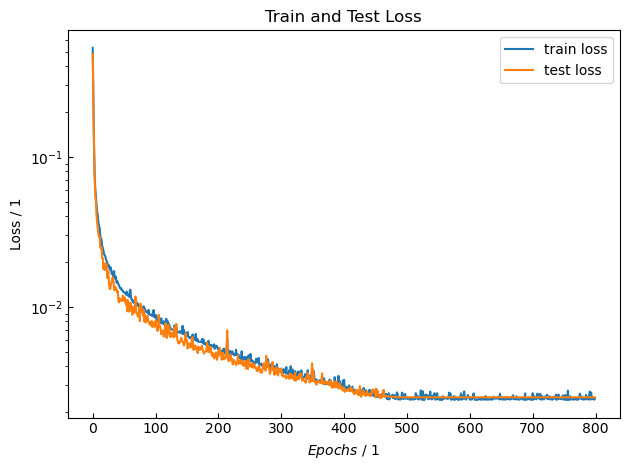

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9984104262250336 , R^2(NH3) = 0.9938246614069809
Test Dataset: R^2(H2) = 0.9983752816441587 , R^2(NH3) = 0.9951193278337955
Max Error Training: |x_H2 - x_H2,pred| = 0.06003117091577059 , |x_NH3 - x_NH3,pred| = 0.05435188025355661
Max Error Test: |x_H2 - x_H2,pred| = 0.03295470161459202 , |x_NH3 - x_NH3,pred| = 0.04450672795328342


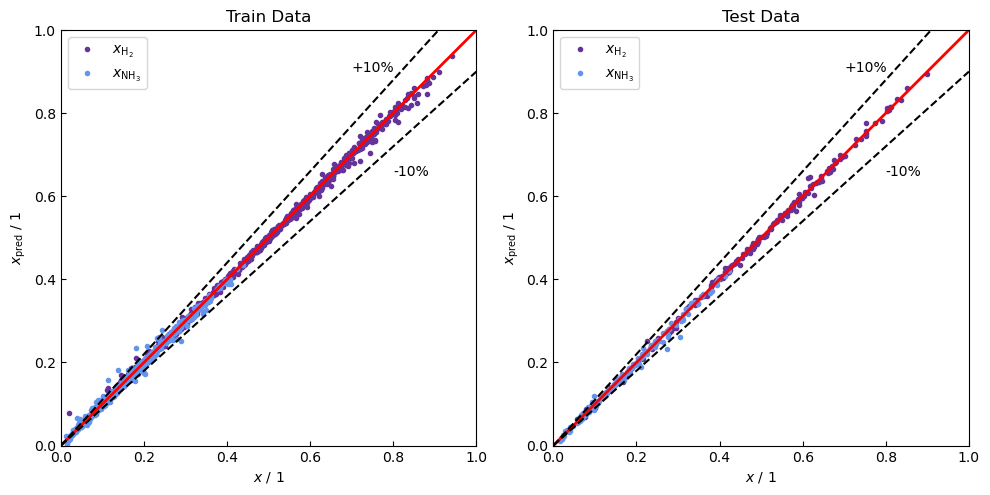

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

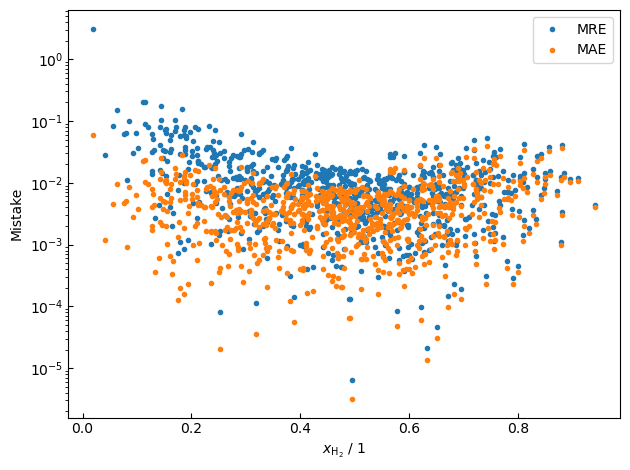

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

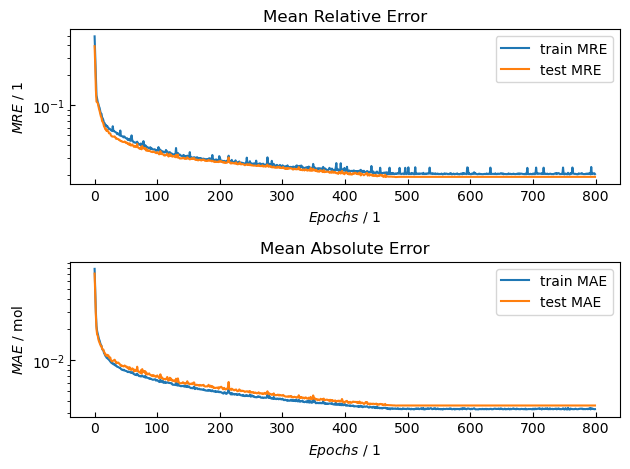

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

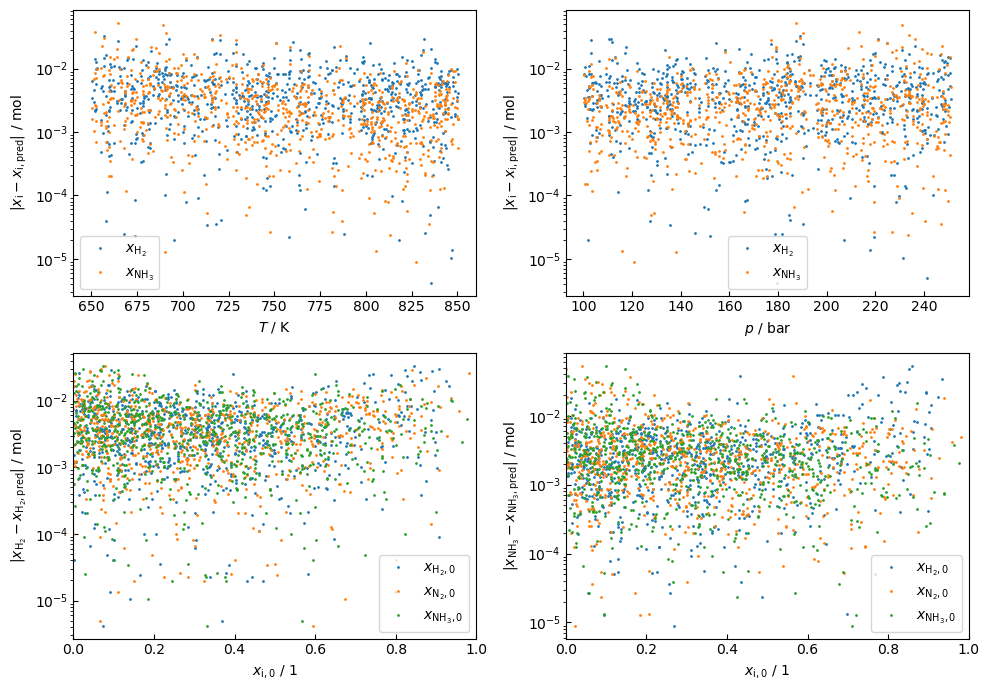

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

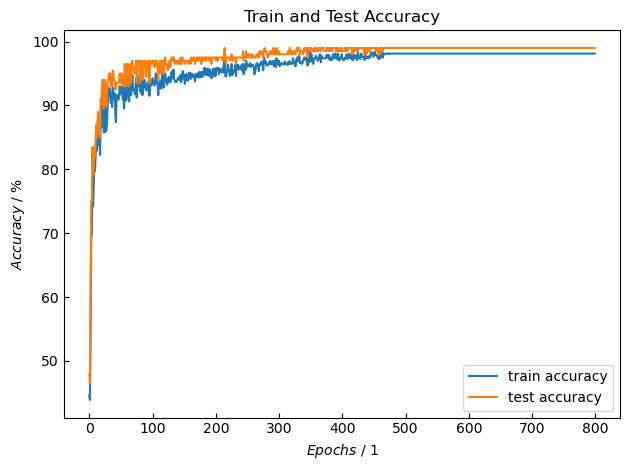

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 7.4539e-01,  1.6291e+00,  1.4267e-01,  1.0845e+00, -1.2484e+00],
        [ 1.3560e+00,  2.0201e-01, -1.0822e+00, -5.7861e-01,  1.6535e+00],
        [ 1.1218e+00, -4.2259e-01,  6.3567e-01, -9.6672e-01,  3.6422e-01],
        [ 6.4162e-01,  9.0515e-02, -4.1377e-01,  2.1817e-01,  1.8308e-01],
        [-3.9412e-01,  9.1316e-01,  4.2615e-01, -4.6728e-01,  5.9380e-02],
        [-1.9498e-01,  1.3053e+00, -2.0781e-01,  1.2658e+00, -1.0898e+00],
        [-1.4826e+00, -1.0141e+00,  1.4888e-02, -1.0017e+00,  1.0092e+00],
        [ 1.9403e-01, -1.4574e+00, -3.0004e-01,  1.5622e+00, -1.3022e+00],
        [ 1.1170e+00,  1.2613e-01,  1.8675e+00, -1.1061e+00, -7.0226e-01],
        [ 9.2303e-01, -1.1778e-01, -1.1215e+00,  9.6405e-01,  1.1525e-01],
        [ 8.7402e-01,  1.3128e+00,  3.0843e-01,  2.2257e-01, -5.3017e-01],
        [-3.3680e-01, -9.1294e-01, -1.0964e+00, -8.5844e-01,  1.9534e+00],
        [ 1.0014e+00,  1.1074e+00,  5.2643e-01,  4.6925e-01, -9.9624e-01],
        [ 9.0258e-01,  1.

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-2.8652e-01, -8.6818e-02,  9.8831e-02, -1.9200e-02,  1.5926e-01],
         [-9.5304e-02,  1.6258e-01,  2.7852e-01, -1.1308e-01,  1.5949e-01],
         [-1.5705e-01, -1.0122e-01, -1.1171e-01, -9.3246e-02, -3.4851e-01],
         [ 1.7882e-01, -2.7777e-01, -3.4398e-02, -2.2393e-01,  2.1834e-01],
         [-2.7562e-01, -3.9640e-01,  7.8527e-02,  3.1008e-01,  2.7761e-01],
         [-1.9416e-01,  1.6904e-01,  1.1570e-01,  3.3797e-01,  1.1417e-01],
         [-1.8727e-02,  3.9383e-01, -1.2786e-01, -2.4625e-01, -4.1026e-01],
         [-1.5403e-01,  1.6793e-01,  3.0082e-01, -4.0964e-01, -2.7210e-01],
         [ 6.0671e-02,  1.2385e-01,  7.3360e-02,  1.6873e-01,  4.1814e-01],
         [-1.8195e-01, -2.7474e-01,  1.0367e-01, -3.1379e-01,  2.0521e-01],
         [-3.4305e-01,  3.7585e-01,  3.8237e-01, -2.5525e-01,  3.1925e-01],
         [-2.8677e-01, -6.8130e-03,  2.4978e-01, -1.0872e-01,  8.5208e-02],
         [ 3.4120e-01,  4.3546e-01,  9.2628e-02,  2.4451e-03,  4.

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.6674, 0.2343, 0.1531, 0.6753, 0.4429],
        [0.0813, 0.3611, 0.2429, 0.5484, 0.3559]])
tensor([[ 0.0355, -0.5539],
        [-0.1099, -0.0157]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 1.1035,  0.3839,  0.2508, -1.2986,  1.0812],
        [ 0.8195, -1.0486, -0.9871,  0.0787,  0.8883],
        [-0.0237,  1.3288,  0.1479, -1.1712,  1.0520],
        [-0.7409, -0.5610, -1.2218,  2.0842, -0.9312],
        [ 0.5683,  1.5450,  0.6013, -0.8992,  0.3290],
        [ 0.0846, -1.4520, -1.3778,  2.6811, -1.3881],
        [-1.1757, -1.6462,  1.5086, -1.3211, -0.1303],
        [-1.7457,  1.6628, -0.0451,  0.3528, -0.3163],
        [ 1.4755, -1.5753,  2.4516, -1.0261, -1.3571],
        [-0.1934, -1.0697, -1.2763, -1.2917,  2.5728],
        [ 0.8221,  0.0494,  0.8854,  0.3826, -1.2599],
        [ 1.0665,  1.3337, -1.3049, -1.0487,  2.3525],
        [ 0.3287, -0.0761, -1.0797, -0.1199,  1.1822],
        [-1.0682, -1.4838,  2.4750, -1.1018, -1.3028],
        [ 1.4410, -1.2162,  2.4382, -1.2450, -1.1203],
        [-0.2241,  0.3003, -0.6554,  1.7655, -1.1613],
        [-0.1335,  0.9987, -1.2047,  2.2949, -1.1633],
        [ 1.2295, -1.2447, -0.2828, -1.2922,  1.5983],
        [-

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()